In this project, we consider predictive analysis with high-frequency data of a major real estate enterprise listed on the Shenzhen Stock Exchange—Vanke Group. Our dataset includes high-resolution timestamps at a frequency of 3 seconds, which gives an extremely granular view of the dynamics of stock prices. Leveraging that data, our aim will be to predict stock movements in the ensuing 3-second window with a suite of Machine Learning algorithms. We will apply and evaluate seven different ML models in a systematic way, in order to establish the one with the most accuracy and predictive performance. This effort is valuable not only for the field of financial analytics but also for working through a concrete case of application of Machine Learning techniques to high-frequency trading data.

# 1 Data preprocessing
## 1.1 Data Import and Visualization

In [1]:
# import libraries
import numpy as np
import pandas as pd
import pandoc
from matplotlib import pyplot as plt


In [2]:
# read data
originDataSet = pd.read_csv("Vanke_HF_Data.csv")

In [3]:
# print the dataframe
originDataSet

,Wind Code,Exchange Code,Date,Time,Transaction Price,Transaction Volume,Transaction Amount,Number of Transactions,Cumulative Transaction Volume,Daily Transaction Amount,...,Bid Volume 5,Bid Volume 6,Bid Volume 7,Bid Volume 8,Bid Volume 9,Bid Volume 10,Weighted Average Asking Price,Weighted Average Bidding Price,Total Ask Volume,Total Bid Volume
0,000002.SZ,2,20240102,91500000,NaN,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,000002.SZ,2,20240102,91509000,NaN,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,000002.SZ,2,20240102,91518000,NaN,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,000002.SZ,2,20240102,91618000,NaN,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,000002.SZ,2,20240102,91630000,NaN,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106224,000002.SZ,2,20240131,145933000,96000.0,0,0,61791,66917192,647335436,...,0,0,0,0,0,0,0,0,0,0
106225,000002.SZ,2,20240131,145942000,96000.0,0,0,61791,66917192,647335436,...,0,0,0,0,0,0,0,0,0,0
106226,000002.SZ,2,20240131,145951000,96000.0,0,0,61791,66917192,647335436,...,0,0,0,0,0,0,0,0,0,0
106227,000002.SZ,2,20240131,150000000,96000.0,0,0,62182,67478860,652727449,...,362600,196100,61100,61600,95700,140200,101600,93700,6726471,3559232


In [4]:
# create a timestamp column
df = pd.DataFrame(originDataSet)

# This function will format the date and time columns into a single Timestamp column
def format_datetime(row):
    date_str = str(row['Date'])
    time_str = str(row['Time']).zfill(9)  # Ensure time is zero-padded to 9 digits

    # Format date and time, 'SS000' part is not relevant for the timestamp
    formatted_date = f"{date_str[:4]}-{date_str[4:6]}-{date_str[6:]}"
    formatted_time = f"{time_str[:2]}:{time_str[2:4]}:{time_str[4:6]}"

    return f"{formatted_date} {formatted_time}"

# Apply the function to create the Timestamp column
df['Timestamp'] = df.apply(format_datetime, axis=1)

# Convert the Timestamp column to datetime type
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%Y-%m-%d %H:%M:%S')

df.head()

,Wind Code,Exchange Code,Date,Time,Transaction Price,Transaction Volume,Transaction Amount,Number of Transactions,Cumulative Transaction Volume,Daily Transaction Amount,...,Bid Volume 6,Bid Volume 7,Bid Volume 8,Bid Volume 9,Bid Volume 10,Weighted Average Asking Price,Weighted Average Bidding Price,Total Ask Volume,Total Bid Volume,Timestamp
0,000002.SZ,2,20240102,91500000,NaN,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2024-01-02 09:15:00
1,000002.SZ,2,20240102,91509000,NaN,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2024-01-02 09:15:09
2,000002.SZ,2,20240102,91518000,NaN,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2024-01-02 09:15:18
3,000002.SZ,2,20240102,91618000,NaN,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2024-01-02 09:16:18
4,000002.SZ,2,20240102,91630000,NaN,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2024-01-02 09:16:30


In [5]:
# Here we check if the 'timestamp' column has unique values
if not df['Timestamp'].is_unique:
    # Handle duplicates here, incase there are any.
    df = df.drop_duplicates(subset='Timestamp')

df = df.set_index('Timestamp')

In [6]:
# remove the first columns that include zeros in the data:
# we need to remove data from 9:15:00 to 9:29:18 for each day
df = df.between_time('09:29:19', '15:00:00')

In [7]:
df.columns

Index(['Wind Code', 'Exchange Code', 'Date', 'Time', 'Transaction Price',
       'Transaction Volume', 'Transaction Amount', 'Number of Transactions',
       'Cumulative Transaction Volume', 'Daily Transaction Amount',
       'Highest Price', 'Lowest Price', 'Opening Price', 'Previous Close',
       'Ask Price 1', 'Ask Price 2', 'Ask Price 3', 'Ask Price 4',
       'Ask Price 5', 'Ask Price 6', 'Ask Price 7', 'Ask Price 8',
       'Ask Price 9', 'Ask Price 10', 'Ask Volume 1', 'Ask Volume 2',
       'Ask Volume 3', 'Ask Volume 4', 'Ask Volume 5', 'Ask Volume 6',
       'Ask Volume 7', 'Ask Volume 8', 'Ask Volume 9', 'Ask Volume 10',
       'Bid Price 1', 'Bid Price 2', 'Bid Price 3', 'Bid Price 4',
       'Bid Price 5', 'Bid Price 6', 'Bid Price 7', 'Bid Price 8',
       'Bid Price 9', 'Bid Price 10', 'Bid Volume 1', 'Bid Volume 2',
       'Bid Volume 3', 'Bid Volume 4', 'Bid Volume 5', 'Bid Volume 6',
       'Bid Volume 7', 'Bid Volume 8', 'Bid Volume 9', 'Bid Volume 10',
       'Weig

In [8]:
# divide all prices columns by 10000 to get the real price in Yuan
price_columns = ['Transaction Price', 'Highest Price', 'Lowest Price', 'Opening Price', 'Previous Close',
                 'Ask Price 1', 'Ask Price 2', 'Ask Price 3', 'Ask Price 4',
                 'Ask Price 5', 'Ask Price 6', 'Ask Price 7', 'Ask Price 8',
                 'Ask Price 9', 'Ask Price 10', 'Bid Price 1', 'Bid Price 2',
                 'Bid Price 3', 'Bid Price 4','Bid Price 5', 'Bid Price 6', 
                 'Bid Price 7', 'Bid Price 8','Bid Price 9', 'Bid Price 10',
                 'Weighted Average Asking Price', 'Weighted Average Bidding Price'
                 ]

df[price_columns] = df[price_columns] / 10000


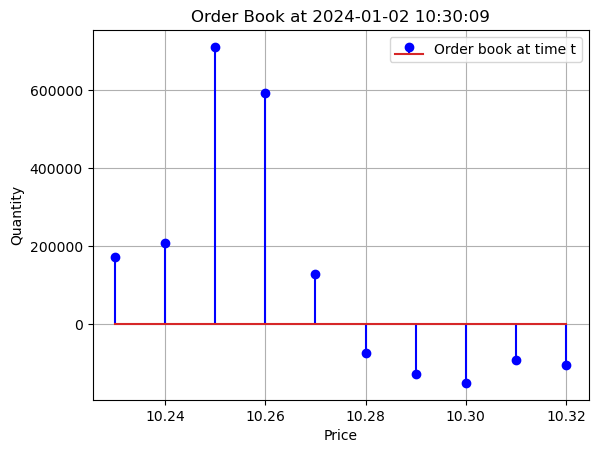

In [9]:
buy_price_columns = ['Bid Price 1', 'Bid Price 2', 'Bid Price 3', 'Bid Price 4', 'Bid Price 5']
sell_price_columns = ['Ask Price 1', 'Ask Price 2', 'Ask Price 3', 'Ask Price 4', 'Ask Price 5']
buy_quantity_columns = ['Bid Volume 1', 'Bid Volume 2', 'Bid Volume 3', 'Bid Volume 4', 'Bid Volume 5']
sell_quantity_columns = ['Ask Volume 1', 'Ask Volume 2', 'Ask Volume 3', 'Ask Volume 4', 'Ask Volume 5']
# 'Transaction Price' is the price at which the last trade was executed
goingprice_column = 'Transaction Price'
#'Transaction Volume' is the volume at which the last trade was executed
volume_column = 'Transaction Volume'

# Selecting data
backfilldata = df.asfreq('3S', method='backfill')[buy_price_columns + sell_price_columns + buy_quantity_columns + sell_quantity_columns].loc['2024-01-02 09:30:00':'2024-01-02 11:30:00']
originaldata = df.asfreq('3S').loc['2024-01-02 09:30:00':'2024-01-02 11:30:00', [goingprice_column, volume_column]]
ourdata = pd.merge(backfilldata, originaldata, how='outer', left_index=True, right_index=True)

# Plot function
def plot_orderbook(ddatetime, data):
    price = data.loc[ddatetime, buy_price_columns + sell_price_columns]
    quantity = pd.concat([data.loc[ddatetime, buy_quantity_columns], -1 * data.loc[ddatetime, sell_quantity_columns]])
    goingprice = data.loc[ddatetime, goingprice_column]
    volume = data.loc[ddatetime, volume_column]
    fig, ax = plt.subplots()
    ax.stem(price, quantity, 'b', markerfmt='bo', label='Order book at time t')
    if pd.notna(goingprice) and pd.notna(volume):
        ax.stem([goingprice], [volume], 'r--', markerfmt='ro', label='Transaction in [t-1,t]')
    ax.legend(loc='upper right')
    plt.xlabel('Price')
    plt.ylabel('Quantity')
    plt.title(f'Order Book at {ddatetime}')
    plt.grid(True)
    plt.show()

# Plot the order book at a specific time
plot_orderbook('2024-01-02 10:30:09', ourdata)


Above represents a graph for the order book of a stock at a given point in time, indicating the quantities of shares with willing order asking and bidding to be bought and sold placed at different costs. The vertical lines indicate the number of shares for each bid or ask, providing a snapshot of market supply and demand.

## 1.2 Dataset Reduction and Cleaning

In [10]:
# here we divided the columns into 5 groups, to help us to understand the data
columns_daily = ['Previous Close', 'Opening Price', 'Highest Price', 'Lowest Price']
columns_price = ['Bid Price 1', 'Bid Price 2', 'Bid Price 3', 'Bid Price 4', 'Bid Price 5', 
                 'Ask Price 1', 'Ask Price 2', 'Ask Price 3', 'Ask Price 4', 'Ask Price 5']
columns_quantity = ['Bid Volume 1', 'Bid Volume 2', 'Bid Volume 3', 'Bid Volume 4', 'Bid Volume 5', 
                    'Ask Volume 1', 'Ask Volume 2', 'Ask Volume 3', 'Ask Volume 4', 'Ask Volume 5']
columns_trade = ['Transaction Price', 'Transaction Volume']
columns_direc = ['Trdirec']
# print the columns
print("Daily Columns:", columns_daily)
print("Price Columns:", columns_price)
print("Quantity Columns:", columns_quantity)
print("Trade Columns:", columns_trade)
print(" Columns:", columns_direc)

Daily Columns: ['Previous Close', 'Opening Price', 'Highest Price', 'Lowest Price']
Price Columns: ['Bid Price 1', 'Bid Price 2', 'Bid Price 3', 'Bid Price 4', 'Bid Price 5', 'Ask Price 1', 'Ask Price 2', 'Ask Price 3', 'Ask Price 4', 'Ask Price 5']
Quantity Columns: ['Bid Volume 1', 'Bid Volume 2', 'Bid Volume 3', 'Bid Volume 4', 'Bid Volume 5', 'Ask Volume 1', 'Ask Volume 2', 'Ask Volume 3', 'Ask Volume 4', 'Ask Volume 5']
Trade Columns: ['Transaction Price', 'Transaction Volume']
 Columns: ['Trdirec']


In [11]:
# Here we create a new column 'Trdirec' to indicate the direction of the transaction
def infer_trdirec(row):
    # Finding the closest price (bid or ask) to the transaction price
    closest_bid = min(row[['Bid Price 1', 'Bid Price 2', 'Bid Price 3', 'Bid Price 4', 'Bid Price 5']], key=lambda x: abs(x - row['Transaction Price']))
    closest_ask = min(row[['Ask Price 1', 'Ask Price 2', 'Ask Price 3', 'Ask Price 4', 'Ask Price 5']], key=lambda x: abs(x - row['Transaction Price']))

    # checking if the transaction price is closer to bid or ask price
    if abs(row['Transaction Price'] - closest_bid) < abs(row['Transaction Price'] - closest_ask):
        return 1  # Closer to bid price, suggesting a sell
    else:
        return 0  # Closer to ask price, suggesting a buy

# Apply the function to your dataframe
df['Trdirec'] = df.apply(infer_trdirec, axis=1)
    
# Sell is mapped to 1 and Buy is mapped to 0

In [12]:
# the purpose of this function is to organize the data and create the 'y' column.
# 'y' column will represent the direction of price change.
def organizeData(df, k):
    # include all columns
    dataSet = df.copy()

    # Apply the infer_trdirec function to infer trade direction
    dataSet['Trdirec'] = df.apply(infer_trdirec, axis=1)

    # Create 'Future Transaction Price' column shifted by k periods
    dataSet['Future Transaction Price'] = dataSet['Transaction Price'].shift(-k)

    # Create 'y' column representing the direction of price change
    dataSet['y'] = dataSet['Future Transaction Price'] - dataSet['Transaction Price']
    dataSet['y'] = dataSet['y'].map(lambda x: 0 if x == 0 else (1 if x > 0 else -1))

    # Drop rows with missing data
    dataSet = dataSet.dropna()

    return dataSet
# this function will return new dataframe which is more has organized data
dataSet = organizeData(df, 1)


In [13]:
# checking the new dataframe
dataSet

,Wind Code,Exchange Code,Date,Time,Transaction Price,Transaction Volume,Transaction Amount,Number of Transactions,Cumulative Transaction Volume,Daily Transaction Amount,...,Bid Volume 8,Bid Volume 9,Bid Volume 10,Weighted Average Asking Price,Weighted Average Bidding Price,Total Ask Volume,Total Bid Volume,Trdirec,Future Transaction Price,y
Timestamp,,,,,,,,,,,,,,,,,,,,,
2024-01-03 09:30:00,000002.SZ,2,20240103,93000000,10.15,0,0,376,302100,3065334,...,64500,232100,16700,10.70,9.92,5882763,3851400,0,10.15,0
2024-01-03 09:30:03,000002.SZ,2,20240103,93003000,10.15,0,0,755,637400,6467123,...,82700,250500,17100,10.66,9.95,6928363,4907700,0,10.15,0
2024-01-03 09:30:06,000002.SZ,2,20240103,93006000,10.15,0,0,807,695400,7055928,...,41400,85700,255600,10.66,9.96,6964563,5118100,0,10.14,-1
2024-01-03 09:30:09,000002.SZ,2,20240103,93009000,10.14,0,0,855,723300,7339098,...,41400,85700,255600,10.66,9.95,6962963,5079700,1,10.15,1
2024-01-03 09:30:12,000002.SZ,2,20240103,93012000,10.15,0,0,907,766800,7779751,...,85700,255600,17100,10.66,9.95,6979107,5063000,0,10.15,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-31 14:59:15,000002.SZ,2,20240131,145915000,9.60,0,0,61791,66917192,647335436,...,0,0,0,0.00,0.00,0,0,0,9.60,0
2024-01-31 14:59:24,000002.SZ,2,20240131,145924000,9.60,0,0,61791,66917192,647335436,...,0,0,0,0.00,0.00,0,0,0,9.60,0
2024-01-31 14:59:33,000002.SZ,2,20240131,145933000,9.60,0,0,61791,66917192,647335436,...,0,0,0,0.00,0.00,0,0,0,9.60,0


## 1.3 Dataset Renaming

In [14]:
# rename data by removing all spaces in column names
# this step is unnecessary, but it is good to have a clean data set and to make everyone in the team use the same column names.
dataSet.columns = dataSet.columns.str.replace(' ', '')
dataSet

,WindCode,ExchangeCode,Date,Time,TransactionPrice,TransactionVolume,TransactionAmount,NumberofTransactions,CumulativeTransactionVolume,DailyTransactionAmount,...,BidVolume8,BidVolume9,BidVolume10,WeightedAverageAskingPrice,WeightedAverageBiddingPrice,TotalAskVolume,TotalBidVolume,Trdirec,FutureTransactionPrice,y
Timestamp,,,,,,,,,,,,,,,,,,,,,
2024-01-03 09:30:00,000002.SZ,2,20240103,93000000,10.15,0,0,376,302100,3065334,...,64500,232100,16700,10.70,9.92,5882763,3851400,0,10.15,0
2024-01-03 09:30:03,000002.SZ,2,20240103,93003000,10.15,0,0,755,637400,6467123,...,82700,250500,17100,10.66,9.95,6928363,4907700,0,10.15,0
2024-01-03 09:30:06,000002.SZ,2,20240103,93006000,10.15,0,0,807,695400,7055928,...,41400,85700,255600,10.66,9.96,6964563,5118100,0,10.14,-1
2024-01-03 09:30:09,000002.SZ,2,20240103,93009000,10.14,0,0,855,723300,7339098,...,41400,85700,255600,10.66,9.95,6962963,5079700,1,10.15,1
2024-01-03 09:30:12,000002.SZ,2,20240103,93012000,10.15,0,0,907,766800,7779751,...,85700,255600,17100,10.66,9.95,6979107,5063000,0,10.15,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-31 14:59:15,000002.SZ,2,20240131,145915000,9.60,0,0,61791,66917192,647335436,...,0,0,0,0.00,0.00,0,0,0,9.60,0
2024-01-31 14:59:24,000002.SZ,2,20240131,145924000,9.60,0,0,61791,66917192,647335436,...,0,0,0,0.00,0.00,0,0,0,9.60,0
2024-01-31 14:59:33,000002.SZ,2,20240131,145933000,9.60,0,0,61791,66917192,647335436,...,0,0,0,0.00,0.00,0,0,0,9.60,0


In [15]:
dataSet.columns

Index(['WindCode', 'ExchangeCode', 'Date', 'Time', 'TransactionPrice',
       'TransactionVolume', 'TransactionAmount', 'NumberofTransactions',
       'CumulativeTransactionVolume', 'DailyTransactionAmount', 'HighestPrice',
       'LowestPrice', 'OpeningPrice', 'PreviousClose', 'AskPrice1',
       'AskPrice2', 'AskPrice3', 'AskPrice4', 'AskPrice5', 'AskPrice6',
       'AskPrice7', 'AskPrice8', 'AskPrice9', 'AskPrice10', 'AskVolume1',
       'AskVolume2', 'AskVolume3', 'AskVolume4', 'AskVolume5', 'AskVolume6',
       'AskVolume7', 'AskVolume8', 'AskVolume9', 'AskVolume10', 'BidPrice1',
       'BidPrice2', 'BidPrice3', 'BidPrice4', 'BidPrice5', 'BidPrice6',
       'BidPrice7', 'BidPrice8', 'BidPrice9', 'BidPrice10', 'BidVolume1',
       'BidVolume2', 'BidVolume3', 'BidVolume4', 'BidVolume5', 'BidVolume6',
       'BidVolume7', 'BidVolume8', 'BidVolume9', 'BidVolume10',
       'WeightedAverageAskingPrice', 'WeightedAverageBiddingPrice',
       'TotalAskVolume', 'TotalBidVolume', 'Trdirec',

# 2 Feature engineering

In this part of our work, we will apply financial engineering to reach key indicators from raw market data, which further brings out the ability of our model to reflect and predict complex market dynamics. We will be able to engineer features such as moving averages and volatility measures in our data with an in-depth insight into the movements of stock prices for use by our ML algorithms.

## 2.1 Feature information generation

In [16]:
def featureEngineering(dataframe):
    ###V1: Ten-level volume and price data
    featV1 = dataframe[['AskPrice1', 'AskPrice2', 'AskPrice3', 'AskPrice4', 'AskPrice5', 'AskVolume1', 'AskVolume2', 'AskVolume3', 'AskVolume4', 'AskVolume5', 'BidPrice1', 'BidPrice2', 'BidPrice3', 'BidPrice4', 'BidPrice5', 'BidVolume1', 'BidVolume2', 'BidVolume3', 'BidVolume4', 'BidVolume5']]
    featV1 = np.array(featV1)

    ###V2: Buy and sell price differences and middle values
    temp1 = featV1[:, 0:5] - featV1[:, 10:15] 
    temp2 = (featV1[:, 0:5] + featV1[:, 10:15]) * 0.5 
    featV2 = np.zeros([temp1.shape[0], temp1.shape[1] + temp2.shape[1]]) # combine the two features
    featV2[:, 0:temp1.shape[1]] = temp1 
    featV2[:, temp1.shape[1]:] = temp2

    ###V3: Various price differences
    temp1 = featV1[:, 4] - featV1[:, 0]
    temp2 = featV1[:, 10] - featV1[:, 14] 
    temp3 = abs(featV1[:, 1:5] - featV1[:, 0:4])  
    temp4 = abs(featV1[:, 11:15] - featV1[:, 10:14]) 
    featV3 = np.zeros([temp1.shape[0], 1 + 1 + temp3.shape[1] + temp4.shape[1]])
    featV3[:, 0] = temp1
    featV3[:, 1] = temp2
    featV3[:, 2:2 + temp3.shape[1]] = temp3
    featV3[:, 2 + temp3.shape[1]:] = temp4

    ###V4: Average prices and volumes
    temp1 = np.mean(featV1[:, 0:5], 1)
    temp2 = np.mean(featV1[:, 10:15], 1) 
    temp3 = np.mean(featV1[:, 5:10], 1)
    temp4 = np.mean(featV1[:, 15:], 1)
    featV4 = np.zeros([temp1.shape[0], 1 + 1 + 1 + 1])
    featV4[:, 0] = temp1
    featV4[:, 1] = temp2
    featV4[:, 2] = temp3
    featV4[:, 3] = temp4

    ###V5: Accumulated price differences, volume differences, and their product differences
    temp1 = np.sum(featV2[:, 0:5], 1)
    temp2 = np.sum(featV1[:, 5:10] - featV1[:, 15:], 1)
    temp3 = featV1[:, 0] * featV1[:, 5] - featV1[:, 10] * featV1[:, 15]
    temp4 = np.sum((featV1[:, 0:5] * featV1[:, 5:10] - featV1[:, 10:15] * featV1[:, 15:]), 1)
    featV5 = np.zeros([temp1.shape[0], 1 + 1 + 1 + 1])
    featV5[:, 0] = temp1
    featV5[:, 1] = temp2
    featV5[:, 2] = temp3
    featV5[:, 3] = temp4

    ##Trade-price Set
    ###V6: Trade price related features: transaction price itself and differences with open, high, low, close prices
    columns_daily = ['PreviousClose', 'OpeningPrice', 'HighestPrice', 'LowestPrice']
    columns_trade_price = ['TransactionPrice']
    price = dataframe[columns_daily + columns_trade_price]
    price = np.array(price)
    temp1 = price[:, -1] - price[:, 0]
    temp2 = price[:, -1] - price[:, 1]
    temp3 = price[:, -1] - price[:, 2]
    temp4 = price[:, -1] - price[:, 3]
    Abseffspread = price[:, -1] - featV2[:, 5]
    tprice = price[:, -1]
    featV6 = np.zeros([temp1.shape[0], 1 + 1 + 1 + 1 + 1 + 1])
    featV6[:, 0] = temp1
    featV6[:, 1] = temp2
    featV6[:, 2] = temp3
    featV6[:, 3] = temp4
    featV6[:, 4] = Abseffspread
    featV6[:, 5] = tprice

    ##Other features
    ###V7: Other features: transaction volume, order book trading trend, next moment trading direction
    columns_trade_volume = ['TransactionVolume']
    columns_direc = ['Trdirec', 'y']
    featV7 = dataframe[columns_trade_volume + columns_direc]
    featV7 = np.array(featV7)

    ##Combining the features
    feat = np.zeros([featV1.shape[0], sum([featV1.shape[1], featV2.shape[1], featV3.shape[1], featV4.shape[1], featV5.shape[1], featV6.shape[1], featV7.shape[1]])])
    feat[:, :featV1.shape[1]] = featV1[:, :]
    feat[:, featV1.shape[1]:featV1.shape[1] + featV2.shape[1]] = featV2[:, :]
    feat[:, featV1.shape[1] + featV2.shape[1]:featV1.shape[1] + featV2.shape[1] + featV3.shape[1]] = featV3[:, :]
    feat[:, featV1.shape[1] + featV2.shape[1] + featV3.shape[1]:featV1.shape[1] + featV2.shape[1] + featV3.shape[1] + featV4.shape[1]] = featV4[:, :]
    feat[:, featV1.shape[1] + featV2.shape[1] + featV3.shape[1] + featV4.shape[1]:featV1.shape[1] + featV2.shape[1] + featV3.shape[1] + featV4.shape[1] + featV5.shape[1]] = featV5[:, :]
    feat[:, featV1.shape[1] + featV2.shape[1] + featV3.shape[1] + featV4.shape[1] + featV5.shape[1]:featV1.shape[1] + featV2.shape[1] + featV3.shape[1] + featV4.shape[1] + featV5.shape[1] + featV6.shape[1]] = featV6
    feat[:, featV1.shape[1] + featV2.shape[1] + featV3.shape[1] + featV4.shape[1] + featV5.shape[1] + featV6.shape[1]:] = featV7[:, :]

    return feat

feat = featureEngineering(dataSet)

In [17]:
feat.shape

(99942, 57)

In [18]:
feat

array([[10.15, 10.16, 10.17, ...,  0.  ,  0.  ,  0.  ],
       [10.15, 10.16, 10.17, ...,  0.  ,  0.  ,  0.  ],
       [10.15, 10.16, 10.17, ...,  0.  ,  0.  , -1.  ],
       ...,
       [ 9.6 ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 9.6 ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 9.6 ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ]])

## 2.2 Lagged item generation

The lag term and acceleration term can be obtained through the addLagging function, and the ignore parameter is the number of features that do not participate in the difference at the tail. Note that the default ignore term is 1, the last one is the predicted value y, and the acceleration term ignore is the original variable dimension, because the residual of the original feature is the lag term, and there will be repetitions.

In [19]:

# the function addLagK is used to add lagged features to the dataset
# the function takes three parameters:
# k: the number of lags to add
# feat: the feature dataset
# ignore: the number of columns to ignore when adding the lagged features
# the function returns the feature dataset with the lagged features added

test1 = np.array([[0,1,2,0],[3,4,5,1],[6,7,8,1],[9,10,11,0],[11,12,13,1]])
def addLagK(k,feat,ignore=1):
    feat_k = feat
    for i in range(1,k+1):
        feat_i = feat[i:,:-ignore]-feat[0:-i,:-ignore]
        feat_k =  np.concatenate((feat_i,feat_k[1:,:]),axis=1)

    return feat_k
# this test is just to check if the function is working correctly
print(addLagK(2,test1))
print(addLagK(1,addLagK(2,test1)))
print(addLagK(1,addLagK(2,test1),test1.shape[1]))

[[ 6  6  6  3  3  3  6  7  8  1]
 [ 6  6  6  3  3  3  9 10 11  0]
 [ 5  5  5  2  2  2 11 12 13  1]]
[[ 0  0  0  0  0  0  3  3  3  6  6  6  3  3  3  9 10 11  0]
 [-1 -1 -1 -1 -1 -1  2  2  2  5  5  5  2  2  2 11 12 13  1]]
[[ 0  0  0  0  0  0  6  6  6  3  3  3  9 10 11  0]
 [-1 -1 -1 -1 -1 -1  5  5  5  2  2  2 11 12 13  1]]


In [20]:
# add two lag terms, one first order acceleration term
data = pd.DataFrame(data=None,columns=dataSet.columns)
num = dataSet.shape[1]
data = featureEngineering(data)
data = addLagK(1,addLagK(2,data),num)
data


array([], shape=(0, 277), dtype=float64)

# 3. Dataset splitting

It is important to understand that there are multiple trading dates in the dataset, and each date contains two periods: morning and afternoon, with the morning session 9:30-11:30 and the afternoon session from 13:00-15:00. Specifically, 9:15-9:25 on each trading day is the opening call auction time. 9:30-11:30 and 13:00-14:57 are continuous bidding times. 14:57-15:00 is the closing call auction time. We only predict the price direction during continuous auctions, that is, we only study the data of the 9:30-11:30 and 13:00-14:57 time periods of each trading day.

On the other hand, let's note the difference between call auction and continuous auction:

The collective competitive price is to gather several entrusted quotations or all the entrusted quotations in a period of time, and generate a transaction price according to the principle of not higher than the bid price and not lower than the bid price, and the number of shares traded at this price is the largest, and this price is used as the transaction price of all transaction orders, which is generally traded at 9:25.

Continuous auctions follow the following rules:

Rules of trading order: 1. Price priority - higher price buy declaration takes precedence over lower price buy declaration, lower price sell declaration takes precedence over higher price sell declaration; 2. Time priority - if the buying and selling direction and price are the same, the first to declare will have priority over the later one.

Rules for the transaction price: 1. The highest buy declaration is the same as the lowest sell declaration price, and the price is used as the transaction price, and the real-time price is formed, and the market is neutral. 2. When the declared price of buying is higher than the lowest declared selling price immediately revealed, the lowest declared selling price revealed immediately shall be used as the transaction price (i.e., the selling price). 3. When the sell declaration price is lower than the highest purchase declaration price immediately revealed, the highest purchase declaration price immediately revealed shall be used as the transaction price (i.e., the buy price).

## 3.1 Time Period:

In [21]:
# Get all unique dates from your dataset
def getDates(dataSet):
    df = dataSet.index.map(lambda x: x.strftime('%Y-%m-%d'))
    npdates = np.unique(np.array(df))
    return npdates
npdates = getDates(dataSet)
npdates

array(['2024-01-03', '2024-01-04', '2024-01-05', '2024-01-08',
       '2024-01-09', '2024-01-10', '2024-01-11', '2024-01-12',
       '2024-01-15', '2024-01-16', '2024-01-17', '2024-01-18',
       '2024-01-19', '2024-01-22', '2024-01-23', '2024-01-24',
       '2024-01-25', '2024-01-26', '2024-01-29', '2024-01-30',
       '2024-01-31'], dtype=object)

In [22]:
# Get all continuous auction trading periods
def getTerms(npdates):
    morning = [" 09:30:00", " 11:30:00"]
    afternoon = [" 13:00:00", " 14:57:00"]
    terms = []
    for date in npdates:
        morning_term = [date + morning[0], date + morning[1]]
        afternoon_term = [date + afternoon[0], date + afternoon[1]]
        terms.append(morning_term)
        terms.append(afternoon_term)
    return terms

npdates = getDates(dataSet)
terms = getTerms(npdates)
terms

[['2024-01-03 09:30:00', '2024-01-03 11:30:00'],
 ['2024-01-03 13:00:00', '2024-01-03 14:57:00'],
 ['2024-01-04 09:30:00', '2024-01-04 11:30:00'],
 ['2024-01-04 13:00:00', '2024-01-04 14:57:00'],
 ['2024-01-05 09:30:00', '2024-01-05 11:30:00'],
 ['2024-01-05 13:00:00', '2024-01-05 14:57:00'],
 ['2024-01-08 09:30:00', '2024-01-08 11:30:00'],
 ['2024-01-08 13:00:00', '2024-01-08 14:57:00'],
 ['2024-01-09 09:30:00', '2024-01-09 11:30:00'],
 ['2024-01-09 13:00:00', '2024-01-09 14:57:00'],
 ['2024-01-10 09:30:00', '2024-01-10 11:30:00'],
 ['2024-01-10 13:00:00', '2024-01-10 14:57:00'],
 ['2024-01-11 09:30:00', '2024-01-11 11:30:00'],
 ['2024-01-11 13:00:00', '2024-01-11 14:57:00'],
 ['2024-01-12 09:30:00', '2024-01-12 11:30:00'],
 ['2024-01-12 13:00:00', '2024-01-12 14:57:00'],
 ['2024-01-15 09:30:00', '2024-01-15 11:30:00'],
 ['2024-01-15 13:00:00', '2024-01-15 14:57:00'],
 ['2024-01-16 09:30:00', '2024-01-16 11:30:00'],
 ['2024-01-16 13:00:00', '2024-01-16 14:57:00'],
 ['2024-01-17 09:30:

## 3.2 Dataset Synthesis

In [23]:
'''
Extract the data from each continuous bidding time period from dataSet,
perform feature processing and lag processing,
and then recombine them into a large dataset.
'''
def getData(dataSet,terms,lagging):
    data = pd.DataFrame(data=None,columns=dataSet.columns)
    data = featureEngineering(data)
    num = data.shape[1]
#     data = addLagK(lagging,data)
    data = addLagK(1,addLagK(lagging,data),num)
    for term in terms:
        term_data = addLagK(1,addLagK(lagging,featureEngineering(dataSet.loc[term[0]:term[1],:])),num)
        data =  np.concatenate((data,term_data),axis=0)
    return data    
        
data = getData(dataSet,terms,2)    
data.shape
# results shows (number of data points, number of features)


(99397, 281)

In [24]:
'''
Rolling split the dataset in chronological order into training sets(with a length of sizeTrain)
and testing sets (with a length of sizeTest), moving forward with a stride length. 
When there is not enough data left for one more stride at the end,
only move forward by the remainder of the stride."

This approach is rolling window.
'''
def getTrainTest(data,sizeTrain,sizeTest,stride):
    pairs =[]
    if (data.shape[0]-sizeTrain-sizeTest)<0:
        print("Size is not enough")
        return pairs
    pairNumber = (data.shape[0]-sizeTrain-sizeTest)//stride
    stump = (data.shape[0]-sizeTrain-sizeTest)%stride
#     print(pairNumber)
#     print(stump)
    for i in range(pairNumber+2):
        if i != pairNumber+1:
            train = np.array(data[i*stride:i*stride+sizeTrain,:])
            test = np.array(data[i*stride+sizeTrain:i*stride+sizeTrain+sizeTest,:])
            pairs.append([train,test])
        elif stump!=0:
            train = np.array(data[(i-1)*stride+stump:(i-1)*stride+sizeTrain+stump,:])
            test = np.array(data[(i-1)*stride+sizeTrain+stump:(i-1)*stride+sizeTrain+sizeTest+stump,:])
            pairs.append([train,test])
#         print([train,test])
        
    return pairs
# this is just a test to check if the function is working correctly
getTrainTest(test1,2,2,2)

[[array([[0, 1, 2, 0],
         [3, 4, 5, 1]]),
  array([[ 6,  7,  8,  1],
         [ 9, 10, 11,  0]])],
 [array([[3, 4, 5, 1],
         [6, 7, 8, 1]]),
  array([[ 9, 10, 11,  0],
         [11, 12, 13,  1]])]]

In [25]:
'''
Transform the dataset into multiple training-testing set pairs with the training set size being 7000,
the test set size being 100, and a stride of 100 pairs = np.array(getTrainTest(data,7000,100,100))
'''
pairs = np.array(getTrainTest(data,7000,100,100), dtype=object)
pairs.shape

(924, 2)

# 4.Normalization

In order to speed up convergence and avoid the dominance of models by variables with large dimensions, we will vertically normalize or standardize the features of each dimension for the dataset.

However, it is important to consider that when using financial time series data for forecasting, we cannot use future information, which would cause the model to fail. Normalization will add the information of future data items (maximum, minimum, mean variance) to past data items, and we cannot use the original method to normalize it. However, if the normalization process is not carried out, the model will have the problem of slow convergence and influence by dimension. Therefore, we should use historical data for normalization.

The maximum and minimum values will be found from the first n data in the dataset, and normalized from this, so that although it is not guaranteed that the processed data is still between 0-1, it can be basically guaranteed to be around 0-1 and there will be no serious dimensional differences.

In [26]:
test = np.array([[0,1],[7,9]])
def normTrain(Train,Train_prev,n):
    ##normalizing the feature
    minTrain = Train_prev[-n:,:].min(axis=0)
    #print(minFeat)
    maxTrain = Train_prev[-n:,:].max(axis=0)
    #print(maxFeat)
    normTrain = (Train - minTrain)/(maxTrain-minTrain)
    return normTrain
# this is just a test to check if the function is working correctly
print(normTrain(test,test,2))

[[0. 0.]
 [1. 1.]]


In [27]:
def normTest(Test,Train,n):
    ##normalizing the feature
    minTrain = Train[-n:,:].min(axis=0)
    #print(minFeat)
    maxTrain = Train[-n:,:].max(axis=0)
    normTest = (Test - minTrain)/(maxTrain-minTrain)
    return normTest

In [28]:
def norm(Train,Test,Train_prev):
    trainNorm= normTrain(Train,Train_prev,Train_prev.shape[0])
    testNorm = normTest(Test,Train,Train.shape[0])
    return trainNorm,testNorm
# this is just a test to check if the function is working correctly
print(norm(test1[:-2],test1[-2:],test1[-2:]))

(array([[-4.5, -4.5, -4.5,  0. ],
       [-3. , -3. , -3. ,  1. ],
       [-1.5, -1.5, -1.5,  1. ]]), array([[1.5       , 1.5       , 1.5       , 0.        ],
       [1.83333333, 1.83333333, 1.83333333, 1.        ]]))


In [29]:
def splitXY(npData):
    x = npData[:,:-1]
    y = npData[:,-1]
    return x,y

In [30]:
data.shape

(99397, 281)

In [31]:
train,test,train_prev = pairs[-1,0],pairs[-1,1], pairs[-2,0]
test

array([[ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  , -1.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  1.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  1.  ,  1.  ],
       ...,
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  1.  ,  1.  ],
       [ 0.01,  0.01,  0.01, ...,  0.  ,  0.  , -1.  ],
       [-9.62, -9.63, -9.64, ...,  0.  ,  0.  ,  0.  ]])

In [32]:
X_train,  y_train = splitXY(train)
X_test, y_test = splitXY(test)
X_train_prev,  _ = splitXY(train_prev)
X_train,X_test = norm(X_train,X_test,X_train_prev)

C:\Users\malne\AppData\Local\Temp\ipykernel_11160\1171770203.py:8: RuntimeWarning: invalid value encountered in divide
  normTrain = (Train - minTrain)/(maxTrain-minTrain)
C:\Users\malne\AppData\Local\Temp\ipykernel_11160\1157917518.py:6: RuntimeWarning: invalid value encountered in divide
  normTest = (Test - minTrain)/(maxTrain-minTrain)


# 5. Variable filtering


Handling large datasets with numerous features can be challenging during model training. The process becomes slower, and the model is more prone to overfitting, mainly when it misinterprets minor features as significant. Dimensionality reduction methods are employed to tackle this. They cut down on the number of features while keeping the data's core characteristics, thus enhancing model performance. Two prevalent dimensionality reduction methods are:

* Lasso Regression: This method excels in feature selection. Lasso regression screens variables based on their relevance to the model's predictive capability. It uses a penalty coefficient, lambda, to modify the influence of features on the model. By adjusting lambda, Lasso regression can effectively reduce the number of variables, retaining only the most impactful ones. This not only makes the model more streamlined but also helps reduce the risk of overfitting.

* Principal Component Analysis (PCA): PCA is a popular dimensionality reduction technique. It reorganizes the dataset so that the new dimensions align with the directions of greatest variance. PCA captures the most significant variance in the data, thereby enhancing the model's explanatory power. This method is especially useful for datasets with many interrelated variables, as it simplifies complexity while maintaining the data's essence.
In summary, both Lasso regression and Principal Component Analysis are robust approaches to reducing a dataset's dimensionality. They improve the model's efficiency and predictive accuracy, either by selecting the most relevant features or by transforming the data into a new set of dimensions.

In [33]:
X_test.shape

(100, 280)

In [34]:
#remove Nan values
X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)

## 5.1 Lasso Screening

In [35]:
from sklearn.linear_model import Lasso
# Variable Selection

lasso = Lasso(0.001)  # Call the Lasso() function, setting the lambda value to 0.01

lasso.fit(X_train, y_train)

print('Lasso regression coefficients:', np.round(lasso.coef_, 5))  # Output the result, retaining five decimal places

# Calculate the number of non-zero correlation coefficients

print('The number of non-zero correlation coefficients:', np.sum(lasso.coef_ != 0))

mask = lasso.coef_ != 0  # Returns a boolean array indicating whether the correlation coefficients are non-zero

print('Whether the correlation coefficients are non-zero:', mask)

X_lasso_train = X_train[:, mask]  # Returns data where the correlation coefficients are non-zero
X_lasso_test = X_test[:, mask]
print('The dimension of the output data:', X_lasso_train.shape)  # View the dimensions of the output data


Lasso regression coefficients: [-0.      -0.      -0.      -0.      -0.      -0.      -0.       0.
 -0.       0.      -0.      -0.      -0.      -0.      -0.       0.
  0.       0.      -0.       0.       0.       0.       0.       0.
  0.      -0.      -0.      -0.      -0.      -0.      -0.       0.
  0.      -0.      -0.      -0.       0.      -0.      -0.      -0.
 -0.      -0.      -0.       0.       0.      -0.0571  -0.      -0.
 -0.      -0.      -0.       0.       0.      -0.       0.      -0.09116
 -0.      -0.      -0.      -0.      -0.      -0.      -0.       0.
 -0.       0.      -0.      -0.      -0.      -0.      -0.       0.
  0.      -0.       0.       0.      -0.      -0.      -0.      -0.
 -0.      -0.      -0.      -0.      -0.      -0.      -0.       0.
  0.      -0.      -0.      -0.       0.      -0.      -0.      -0.
 -0.      -0.      -0.       0.      -0.      -0.      -0.      -0.
 -0.      -0.      -0.      -0.       0.      -0.       0.       0.
 -0.      -0

# 6. Evaluation Metrics for Classification

## 6.1 Metrics were used in this study

Due to the different proportions of different categories in the data set, most of them are constant prices, and only by increasing the accuracy and check of the rise and fall, such a model can effectively support the generation of quantitative strategies, so it cannot rely on accuracy as the only evaluation index, and the f1_score should also be considered.

accuracy_score(y_true,y_pre) : Accuracy

f1_score(y_true, y_pred, labels=None, pos_label=1, average='binary', sample_weight=None): F1 value F1 = 2 (precision.) recall) / (precision + recall) precision = TP / (TP + FP) recall = TP / (TP + FN) There are multiple types of f1_score The macro averaging method is used.

confusion_matrix(y_true, y_pred, labels=None, sample_weight=None): Evaluates the accuracy of classification by calculating the confusion matrix Returns the confusion matrix

time The time taken for model training

In [36]:
#Evaluation Metrics
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,roc_auc_score

In [37]:
import time
def getMultiLearningResult(model,X_train,y_train,X_test,y_test):
    # Training
    start_time = time.time()
    trainedModel = model.fit(X_train, y_train)
    t = time.time() - start_time
    
    #accuracy = logreg.score(X_test, y_test)
    y_pred = trainedModel.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
#     roc_auc = roc_auc_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    f1 = f1_score(y_test, y_pred,average = "macro")
    
    print("time:", t)
    print(trainedModel.__class__.__name__+" Model's Training set score: {:.3f}".format(trainedModel.score(X_train, y_train)))
    print(trainedModel.__class__.__name__+" Model's Test set score: {:.3f}".format(trainedModel.score(X_test, y_test)))
    
    return {'accuracy': accuracy, 'time': t,  'f1': f1, 'confusion': confusion, 'trainedModel': trainedModel,"y_pred":y_pred}

## 6.3 Draw a heat map

In [38]:
import seaborn as sns

def drawConfusion(conf_array):
    row_indices = ["Price Up_True", "Price Stationary_True", "Price Down_True"]
    column_names = ["Price Up_Predict", "Price Stationary_Predict", "Price Down_Predict"]
    
    conf_df = pd.DataFrame(conf_array, index=row_indices, columns=column_names)
    
    print("The DataFrame of the Confusion Matrix generated is:")
    print(conf_df)
    
    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(10, 7))
    heatmap = sns.heatmap(conf_df, cmap='coolwarm', cbar=True)
    
    # Annotate each cell with the respective numeric value
    for i in range(conf_df.shape[0]):
        for j in range(conf_df.shape[1]):
            text = ax.text(j + 0.5, i + 0.5, conf_df.iloc[i, j],
                           ha="center", va="center", color="black")
    
    plt.xlabel('Predictions')
    plt.ylabel('Reality')
    plt.title('Confusion Matrix')
    plt.show()

    return heatmap

In [39]:
X_train.shape

(7000, 280)

In [40]:
X_test.shape

(100, 280)

In [41]:
y_test.shape

(100,)

In [42]:
y_test

array([-1.,  0.,  1.,  0.,  0., -1., -1.,  0.,  0.,  0.,  1.,  1., -1.,
        0.,  0.,  0.,  0.,  1., -1.,  1., -1.,  0.,  0.,  1.,  0., -1.,
        0.,  1.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  1., -1.,  0.,
        1., -1.,  1., -1., -1.,  0.,  0.,  1., -1.,  0.,  1.,  0.,  0.,
        0., -1.,  1., -1.,  0.,  1., -1.,  1., -1.,  0.,  0.,  0.,  1.,
       -1.,  1., -1.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  1., -1.,  1.,
        0., -1.,  0.,  1.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0., -1.,  1., -1.,  0.])

# 7. Model training

## 7.1 Logistic Regression Analysis (Shirley)

In [43]:
from sklearn.linear_model import LogisticRegression
#Classification by Logistic Regression
def logReg(X_train,y_train,X_test,y_test):

    logreg = LogisticRegression(class_weight={-1: 0.3,0: 0.2, 1: 0.4})
    
    result = getMultiLearningResult(logreg,X_train,y_train,X_test,y_test)
    logreg = result["trainedModel"]
    
#     print("\nlr.coef_:", logreg.coef_)
#     print("lr.intercept_:", logreg.intercept_)
    
    return result


LogReg = logReg(X_train,y_train,X_test,y_test)
LogReg

time: 0.8486058712005615
LogisticRegression Model's Training set score: 0.571
LogisticRegression Model's Test set score: 0.510


c:\Users\malne\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'accuracy': 0.51,
 'time': 0.8486058712005615,
 'f1': 0.5116656253254191,
 'confusion': array([[11, 14,  0],
        [12, 24, 18],
        [ 0,  5, 16]], dtype=int64),
 'trainedModel': LogisticRegression(class_weight={-1: 0.3, 0: 0.2, 1: 0.4}),
 'y_pred': array([ 0.,  1.,  1., -1., -1.,  0.,  0.,  1.,  1.,  1.,  1.,  0., -1.,
         1.,  1.,  0., -1.,  0.,  0.,  1., -1.,  1.,  1.,  1., -1., -1.,
         1.,  1., -1., -1.,  0.,  0.,  0.,  0.,  0.,  1.,  1., -1.,  1.,
         1., -1.,  0., -1.,  0.,  1.,  1.,  0., -1.,  1.,  1., -1., -1.,
         0.,  0.,  1.,  0.,  1.,  1., -1.,  1., -1.,  1.,  0.,  0.,  0.,
        -1.,  1., -1.,  1.,  1.,  0.,  0.,  0., -1.,  0.,  1.,  0.,  1.,
        -1.,  0.,  0.,  1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0., -1.])}

The DataFrame of the Confusion Matrix generated is:
                       Price Up_Predict  Price Stationary_Predict  \
Price Up_True                        11                        14   
Price Stationary_True                12                        24   
Price Down_True                       0                         5   

                       Price Down_Predict  
Price Up_True                           0  
Price Stationary_True                  18  
Price Down_True                        16  


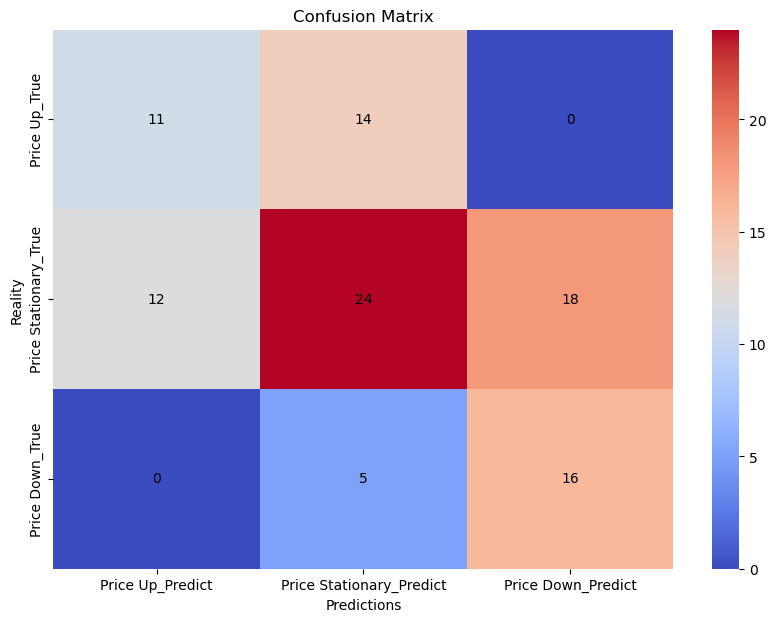

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predictions', ylabel='Reality'>

In [44]:
drawConfusion(LogReg["confusion"])

In [45]:
LogRegLasso = logReg(X_lasso_train,y_train,X_lasso_test,y_test)
LogRegLasso

time: 0.2837343215942383
LogisticRegression Model's Training set score: 0.565
LogisticRegression Model's Test set score: 0.510


c:\Users\malne\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'accuracy': 0.51,
 'time': 0.2837343215942383,
 'f1': 0.5137344619842904,
 'confusion': array([[11, 14,  0],
        [11, 22, 21],
        [ 0,  3, 18]], dtype=int64),
 'trainedModel': LogisticRegression(class_weight={-1: 0.3, 0: 0.2, 1: 0.4}),
 'y_pred': array([ 0.,  1.,  1., -1., -1.,  0.,  0.,  1.,  1.,  1.,  1.,  0., -1.,
         1.,  1.,  0.,  0.,  1.,  0.,  1., -1.,  1.,  1.,  1., -1., -1.,
         1.,  1., -1., -1.,  0.,  0.,  0.,  0.,  0.,  1.,  1., -1.,  1.,
         1., -1.,  0., -1.,  0.,  1.,  1.,  1., -1.,  1.,  1., -1., -1.,
         0.,  0.,  1.,  0.,  1.,  1., -1.,  1., -1.,  1.,  1.,  1.,  0.,
        -1.,  1., -1.,  1.,  1.,  1.,  0., -1.,  0.,  0.,  1.,  0.,  1.,
        -1.,  0.,  0.,  1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0., -1.])}

The DataFrame of the Confusion Matrix generated is:
                       Price Up_Predict  Price Stationary_Predict  \
Price Up_True                        11                        14   
Price Stationary_True                11                        22   
Price Down_True                       0                         3   

                       Price Down_Predict  
Price Up_True                           0  
Price Stationary_True                  21  
Price Down_True                        18  


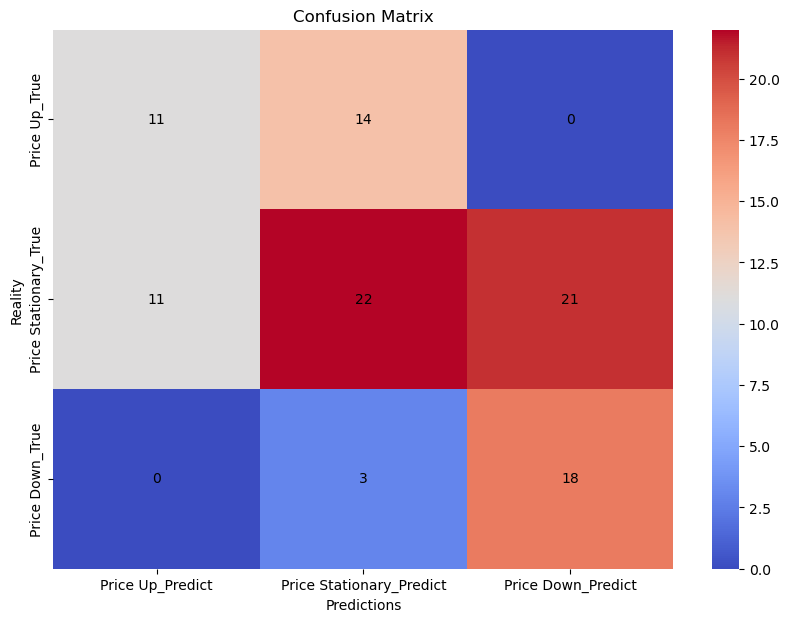

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predictions', ylabel='Reality'>

In [46]:
drawConfusion(LogRegLasso["confusion"])

## 7.2 Decision Tree Classifier (Shirley)

In [47]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV


# Decision Tree - Parameter Tuning
def decTreeTuning(X_train,y_train,X_test,y_test):
    # max_depth: The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
    # min_samples_split: The minimum number of samples required to split an internal node.
    # min_samples_leaf: The minimum number of samples required to be at a leaf node
    # max_leaf_nodes: The maximum number of leaf nodes
    tree = DecisionTreeClassifier(random_state = 0)
    param_DT = {"max_depth": [10,15],
           "min_samples_split": [10,20,50],}
    grid_tree = GridSearchCV(tree,param_DT,cv=5)
    
    
    result = getMultiLearningResult(grid_tree,X_train,y_train,X_test,y_test)
    grid_tree = result["trainedModel"]
    
    print("\ntree.best_params:",grid_tree.best_params_)
    
    return result

decTreeTuning(X_lasso_train,y_train,X_lasso_test,y_test)

time: 6.32044529914856
GridSearchCV Model's Training set score: 0.741
GridSearchCV Model's Test set score: 0.520

tree.best_params: {'max_depth': 10, 'min_samples_split': 10}


{'accuracy': 0.52,
 'time': 6.32044529914856,
 'f1': 0.42757936507936506,
 'confusion': array([[10, 15,  0],
        [ 7, 39,  8],
        [ 0, 18,  3]], dtype=int64),
 'trainedModel': GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0),
              param_grid={'max_depth': [10, 15],
                          'min_samples_split': [10, 20, 50]}),
 'y_pred': array([ 0.,  0.,  0.,  0.,  1., -1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  1.,  0.,  0., -1., -1.,
         1.,  0., -1.,  0., -1., -1., -1., -1., -1.,  0.,  0.,  0.,  0.,
         0., -1.,  0.,  0.,  0.,  1.,  0.,  0., -1.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  1., -1.,  0.,  0.,  0.,  0.,
        -1.,  0., -1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0., -1.,  0.,
         0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.])}

In [48]:
# Classification by Decision Tree
def decTree(X_train,y_train,X_test,y_test):
    # max_depth: The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
    # min_samples_split: The minimum number of samples required to split an internal node.
    # min_samples_leaf: The minimum number of samples required to be at a leaf node
    # max_leaf_nodes: The maximum number of leaf nodes
    tree = DecisionTreeClassifier(random_state = 0,max_depth=10,min_samples_split=20)    
    result = getMultiLearningResult(tree,X_train,y_train,X_test,y_test)
    tree = result["trainedModel"]

    
    return result


DecTree ={}
DecTree = decTree(X_train,y_train,X_test,y_test)
DecTree

time: 1.2911756038665771
DecisionTreeClassifier Model's Training set score: 0.756
DecisionTreeClassifier Model's Test set score: 0.540


{'accuracy': 0.54,
 'time': 1.2911756038665771,
 'f1': 0.3885564304461943,
 'confusion': array([[13, 12,  0],
        [11, 41,  2],
        [ 1, 20,  0]], dtype=int64),
 'trainedModel': DecisionTreeClassifier(max_depth=10, min_samples_split=20, random_state=0),
 'y_pred': array([-1.,  0.,  0., -1.,  0., -1.,  0.,  1.,  0.,  0.,  0.,  0., -1.,
         0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., -1.,  0., -1., -1., -1., -1., -1.,  1.,  0., -1.,  0.,
         0., -1., -1.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0., -1.,  0., -1.,  0.,  0.,  0.,  0.,
        -1.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0., -1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0., -1., -1.,  0., -1.,  0.,  0.,  0.,
        -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.])}

The DataFrame of the Confusion Matrix generated is:
                       Price Up_Predict  Price Stationary_Predict  \
Price Up_True                        13                        12   
Price Stationary_True                11                        41   
Price Down_True                       1                        20   

                       Price Down_Predict  
Price Up_True                           0  
Price Stationary_True                   2  
Price Down_True                         0  


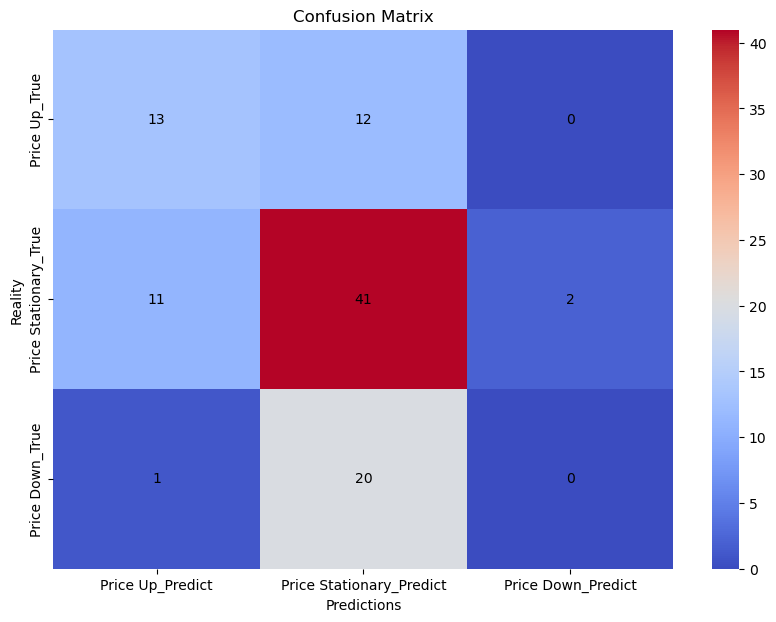

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predictions', ylabel='Reality'>

In [49]:
drawConfusion(DecTree["confusion"])

In [50]:
DecTreeLasso = decTree(X_lasso_train,y_train,X_lasso_test,y_test)
DecTreeLasso

time: 0.21066856384277344
DecisionTreeClassifier Model's Training set score: 0.729
DecisionTreeClassifier Model's Test set score: 0.520


{'accuracy': 0.52,
 'time': 0.21066856384277344,
 'f1': 0.4414626065479956,
 'confusion': array([[10, 15,  0],
        [ 7, 38,  9],
        [ 0, 17,  4]], dtype=int64),
 'trainedModel': DecisionTreeClassifier(max_depth=10, min_samples_split=20, random_state=0),
 'y_pred': array([ 0.,  0.,  0.,  0.,  1., -1.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,
         1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  1.,  0.,  0., -1., -1.,
         1.,  0., -1.,  0., -1., -1., -1., -1., -1.,  1.,  0.,  0.,  0.,
         0., -1.,  0.,  0.,  0.,  1.,  0.,  0., -1.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  1., -1.,  0.,  0.,  0.,  0.,
        -1.,  0., -1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0., -1.,  0.,
         0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.])}

The DataFrame of the Confusion Matrix generated is:
                       Price Up_Predict  Price Stationary_Predict  \
Price Up_True                        10                        15   
Price Stationary_True                 7                        38   
Price Down_True                       0                        17   

                       Price Down_Predict  
Price Up_True                           0  
Price Stationary_True                   9  
Price Down_True                         4  


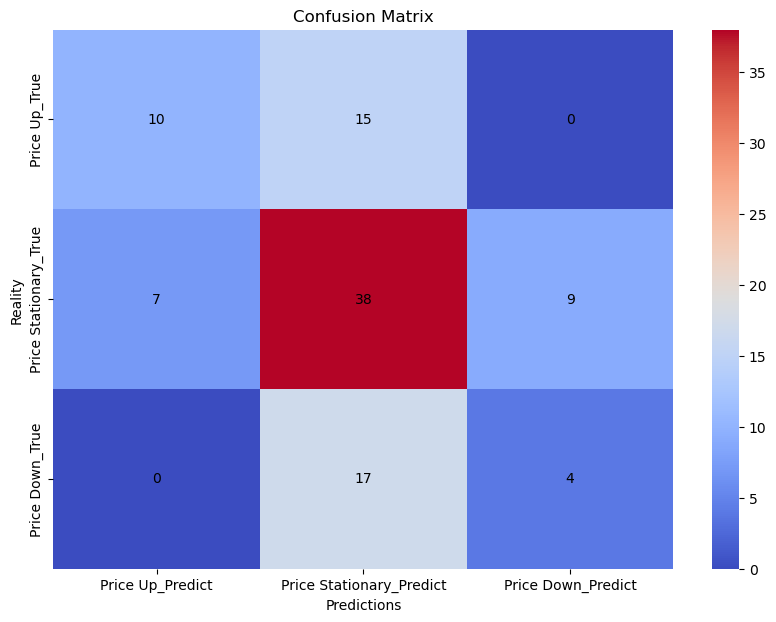

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predictions', ylabel='Reality'>

In [51]:
drawConfusion(DecTreeLasso["confusion"])


## 7.3 K-Nearest Neighbors (KNN) Method (George)


In [52]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
#Check model accuracy based on a pre-specified KNN number
def KNN_Classification(X_train, y_train, X_test, y_test):
#n_neighbors: The nearest n neighbors show us how to classify a new observation(which class to assign it to)
#Here, we chose KNN=10 because we know that from the lasso testing later, KNN=10 gives us the highest accuracy
    knn = KNeighborsClassifier(n_neighbors=10)
    result = getMultiLearningResult(knn, X_train, y_train, X_test, y_test)
    grid_knn = result["trainedModel"]
    return result

KNN = KNN_Classification(X_train, y_train, X_test, y_test)
print(KNN)

time: 0.005522489547729492
KNeighborsClassifier Model's Training set score: 0.668
KNeighborsClassifier Model's Test set score: 0.550
{'accuracy': 0.55, 'time': 0.005522489547729492, 'f1': 0.5153508771929824, 'confusion': array([[11, 14,  0],
       [11, 35,  8],
       [ 1, 11,  9]], dtype=int64), 'trainedModel': KNeighborsClassifier(n_neighbors=10), 'y_pred': array([-1.,  0.,  1., -1., -1.,  0.,  0.,  1.,  0.,  0.,  0.,  1., -1.,
        0.,  1., -1., -1.,  0.,  0.,  0., -1.,  1.,  1.,  0., -1., -1.,
        0.,  1., -1., -1., -1.,  0.,  0.,  0.,  0.,  0.,  1., -1.,  0.,
        1., -1., -1., -1., -1.,  1.,  0.,  0., -1.,  0.,  0., -1., -1.,
        0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
       -1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  0., -1.])}


The DataFrame of the Confusion Matrix generated is:
                       Price Up_Predict  Price Stationary_Predict  \
Price Up_True                        11                        14   
Price Stationary_True                11                        35   
Price Down_True                       1                        11   

                       Price Down_Predict  
Price Up_True                           0  
Price Stationary_True                   8  
Price Down_True                         9  


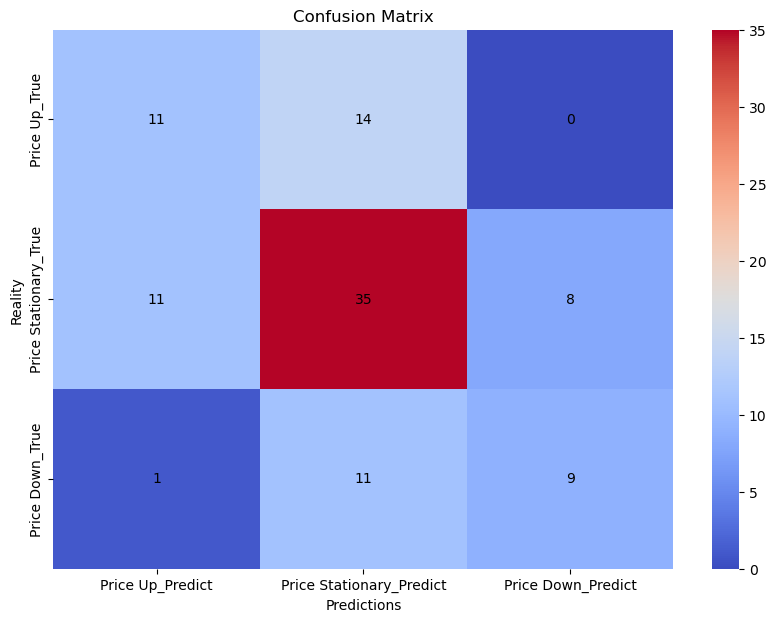

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predictions', ylabel='Reality'>

In [53]:
drawConfusion(KNN["confusion"])

In [54]:
KNNLasso = KNN_Classification(X_lasso_train,y_train,X_lasso_test,y_test)
KNNLasso

time: 0.0023822784423828125
KNeighborsClassifier Model's Training set score: 0.664
KNeighborsClassifier Model's Test set score: 0.590


{'accuracy': 0.59,
 'time': 0.0023822784423828125,
 'f1': 0.492822279643985,
 'confusion': array([[11, 14,  0],
        [ 8, 44,  2],
        [ 0, 17,  4]], dtype=int64),
 'trainedModel': KNeighborsClassifier(n_neighbors=10),
 'y_pred': array([ 0.,  0.,  0.,  0.,  0., -1.,  0.,  1.,  0.,  0.,  0.,  1., -1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0., -1.,
         1.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,
         0., -1.,  0., -1.,  0.,  0.,  0.,  0., -1.,  0.,  0., -1.,  0.,
        -1.,  0.,  1.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,
        -1.,  0., -1.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  1.,
        -1.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0., -1.,  0.,  1.,  0., -1.])}

The DataFrame of the Confusion Matrix generated is:
                       Price Up_Predict  Price Stationary_Predict  \
Price Up_True                        11                        14   
Price Stationary_True                 8                        44   
Price Down_True                       0                        17   

                       Price Down_Predict  
Price Up_True                           0  
Price Stationary_True                   2  
Price Down_True                         4  


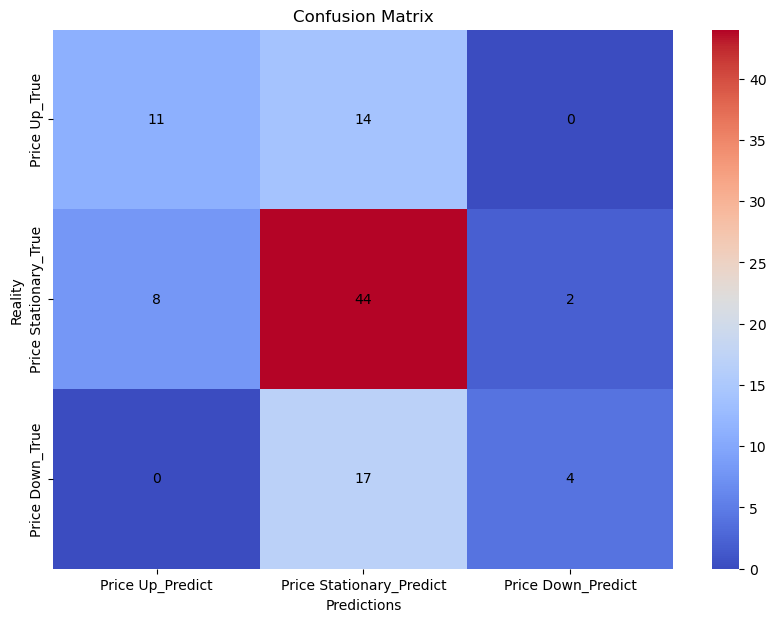

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predictions', ylabel='Reality'>

In [55]:
drawConfusion(KNNLasso["confusion"])


## 7.4 Naive Bayes Classification (George)

In [56]:
from sklearn.naive_bayes import BernoulliNB

def naiveBayes(X_train,y_train,X_test,y_test):
    nb = BernoulliNB()
    result = getMultiLearningResult(nb,X_train,y_train,X_test,y_test)
    nb = result["trainedModel"]
    return result



NB ={}
NB = naiveBayes(X_train,y_train,X_test,y_test)
NB

time: 0.04361748695373535
BernoulliNB Model's Training set score: 0.577
BernoulliNB Model's Test set score: 0.590


{'accuracy': 0.59,
 'time': 0.04361748695373535,
 'f1': 0.44370782701138395,
 'confusion': array([[13, 12,  0],
        [ 9, 45,  0],
        [ 0, 20,  1]], dtype=int64),
 'trainedModel': BernoulliNB(),
 'y_pred': array([ 0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -1.,
         0.,  0., -1.,  0.,  0., -1.,  0., -1.,  0.,  0.,  0., -1.,  0.,
         0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,
         0., -1.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0., -1.,  0.,
         0.,  0.,  0., -1.,  0.,  0., -1.,  0., -1.,  0.,  0.,  0.,  0.,
        -1.,  0., -1.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0., -1.,  0.,
        -1.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0., -1., -1.])}

The DataFrame of the Confusion Matrix generated is:
                       Price Up_Predict  Price Stationary_Predict  \
Price Up_True                        13                        12   
Price Stationary_True                 9                        45   
Price Down_True                       0                        20   

                       Price Down_Predict  
Price Up_True                           0  
Price Stationary_True                   0  
Price Down_True                         1  


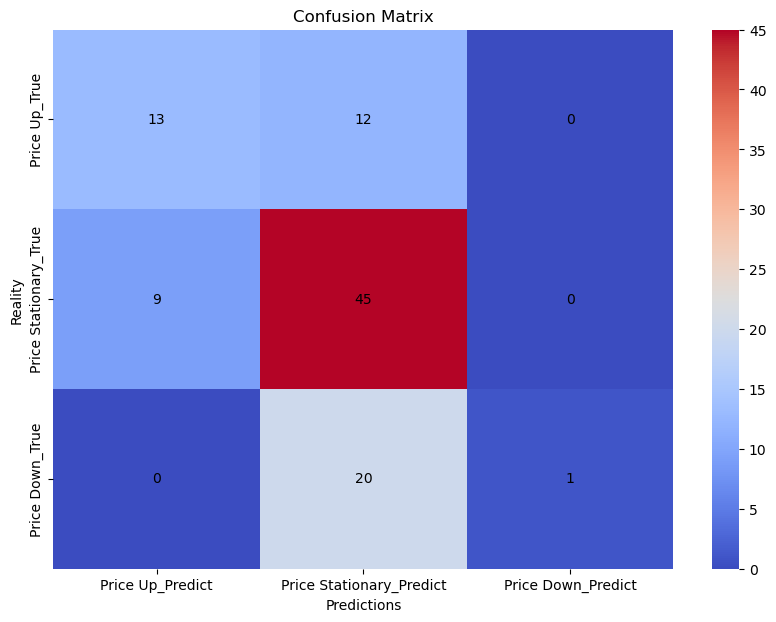

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predictions', ylabel='Reality'>

In [57]:
drawConfusion(NB["confusion"])

In [58]:
NBLasso = naiveBayes(X_lasso_train,y_train,X_lasso_test,y_test)
NBLasso

time: 0.00799417495727539
BernoulliNB Model's Training set score: 0.552
BernoulliNB Model's Test set score: 0.550


{'accuracy': 0.55,
 'time': 0.00799417495727539,
 'f1': 0.40024925702233727,
 'confusion': array([[16,  9,  0],
        [15, 39,  0],
        [ 1, 20,  0]], dtype=int64),
 'trainedModel': BernoulliNB(),
 'y_pred': array([-1.,  0.,  0., -1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,
         0.,  0., -1., -1.,  0., -1.,  0., -1.,  0.,  0.,  0., -1., -1.,
         0.,  0., -1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,
         0., -1., -1.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0., -1., -1.,
         0.,  0.,  0., -1.,  0.,  0., -1.,  0., -1.,  0.,  0.,  0.,  0.,
        -1.,  0., -1.,  0.,  0.,  0., -1., -1.,  0.,  0.,  0., -1.,  0.,
        -1., -1.,  0.,  0., -1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0., -1., -1.])}

The DataFrame of the Confusion Matrix generated is:
                       Price Up_Predict  Price Stationary_Predict  \
Price Up_True                        16                         9   
Price Stationary_True                15                        39   
Price Down_True                       1                        20   

                       Price Down_Predict  
Price Up_True                           0  
Price Stationary_True                   0  
Price Down_True                         0  


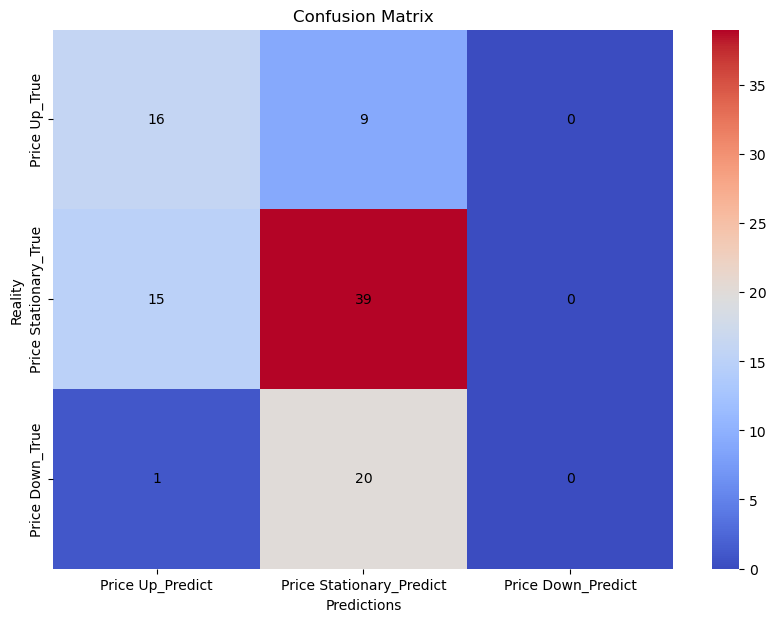

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predictions', ylabel='Reality'>

In [59]:
drawConfusion(NBLasso["confusion"])


## 7.5 Support Vector Machine (SVM) Implementation (Vivan Sun)


### 7.5.1 Linear SVM

In [60]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

def linearSVMTuning(X_train,y_train,X_test,y_test):
    #define a list of parameters
    params_svc = {'C': [1,10]}
    linear_svc = LinearSVC()
    grid_svc = GridSearchCV(linear_svc, params_svc, cv=3, n_jobs=-1,scoring = 'f1_macro', return_train_score=True)
    
    
    result = getMultiLearningResult(grid_svc,X_train,y_train,X_test,y_test)
    grid_svc = result["trainedModel"]
    
    print(grid_svc.best_params_)
    return result





linearSVMTuning(X_train,y_train,X_test,y_test)

c:\Users\malne\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


time: 44.839412212371826
GridSearchCV Model's Training set score: 0.353
GridSearchCV Model's Test set score: 0.277
{'C': 1}


c:\Users\malne\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'accuracy': 0.52,
 'time': 44.839412212371826,
 'f1': 0.27658324991658323,
 'confusion': array([[ 1, 24,  0],
        [ 1, 50,  3],
        [ 0, 20,  1]], dtype=int64),
 'trainedModel': GridSearchCV(cv=3, estimator=LinearSVC(), n_jobs=-1, param_grid={'C': [1, 10]},
              return_train_score=True, scoring='f1_macro'),
 'y_pred': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.])}

In [61]:
from sklearn.svm import LinearSVC

def linearSVM(X_train,y_train,X_test,y_test):
    linear_svc = LinearSVC(C=1)
   
        
    result = getMultiLearningResult(linear_svc,X_train,y_train,X_test,y_test)
    linear_svc = result["trainedModel"]
    
    return result




LinearSVM ={}
LinearSVM= linearSVM(X_train,y_train,X_test,y_test)
LinearSVM

c:\Users\malne\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


time: 22.48786497116089
LinearSVC Model's Training set score: 0.633
LinearSVC Model's Test set score: 0.520


c:\Users\malne\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'accuracy': 0.52,
 'time': 22.48786497116089,
 'f1': 0.27658324991658323,
 'confusion': array([[ 1, 24,  0],
        [ 1, 50,  3],
        [ 0, 20,  1]], dtype=int64),
 'trainedModel': LinearSVC(C=1),
 'y_pred': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.])}

The DataFrame of the Confusion Matrix generated is:
                       Price Up_Predict  Price Stationary_Predict  \
Price Up_True                         1                        24   
Price Stationary_True                 1                        50   
Price Down_True                       0                        20   

                       Price Down_Predict  
Price Up_True                           0  
Price Stationary_True                   3  
Price Down_True                         1  


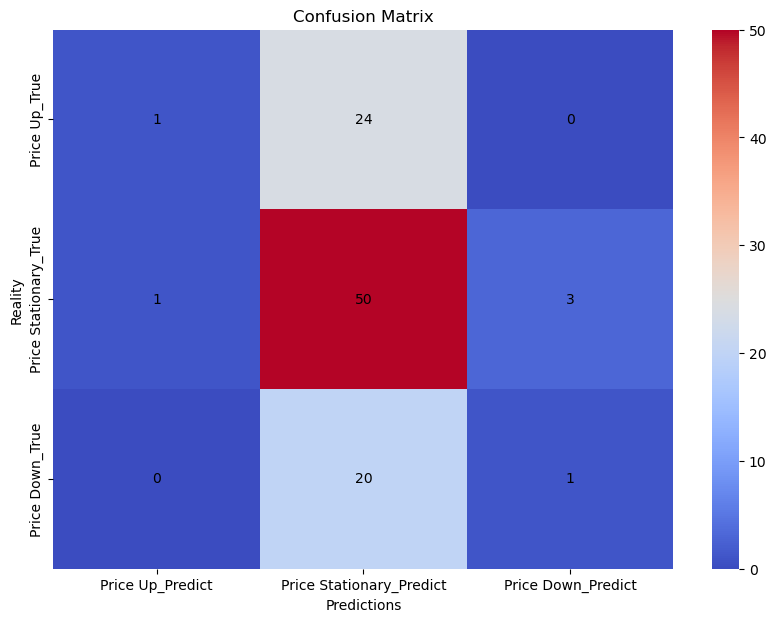

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predictions', ylabel='Reality'>

In [62]:
drawConfusion(LinearSVM["confusion"])

In [63]:
LinearSVMLasso = linearSVM(X_lasso_train,y_train,X_lasso_test,y_test)
LinearSVMLasso

c:\Users\malne\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


time: 0.46210312843322754
LinearSVC Model's Training set score: 0.621
LinearSVC Model's Test set score: 0.510


{'accuracy': 0.51,
 'time': 0.46210312843322754,
 'f1': 0.2503803131991051,
 'confusion': array([[ 0, 25,  0],
        [ 1, 50,  3],
        [ 0, 20,  1]], dtype=int64),
 'trainedModel': LinearSVC(C=1),
 'y_pred': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.])}

The DataFrame of the Confusion Matrix generated is:
                       Price Up_Predict  Price Stationary_Predict  \
Price Up_True                         0                        25   
Price Stationary_True                 1                        50   
Price Down_True                       0                        20   

                       Price Down_Predict  
Price Up_True                           0  
Price Stationary_True                   3  
Price Down_True                         1  


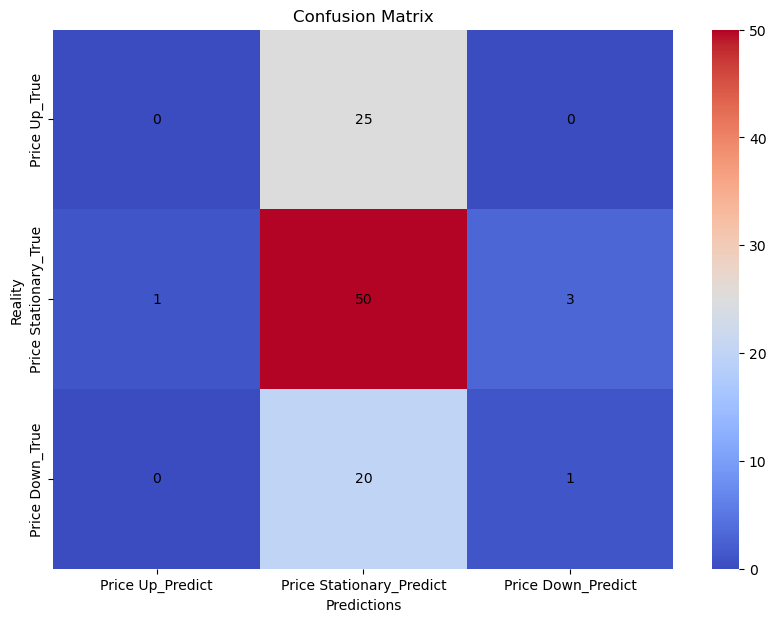

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predictions', ylabel='Reality'>

In [64]:
drawConfusion(LinearSVMLasso["confusion"])

### 7.5.2 Kernel SVM

In [65]:
from sklearn.svm import SVC

def kernelSVMTuning(X_train,y_train,X_test,y_test):
    
    svc_kernel = SVC(kernel = 'rbf')
    #define a list of parameters
    param_svc_kernel = {'C': [20,30,30],'gamma':[0.01,0.05,0.1]}
    #apply grid search
    grid_svc_kernel = GridSearchCV(svc_kernel, param_svc_kernel, cv=5, n_jobs=-1, scoring='f1_macro')
    
    
    result = getMultiLearningResult(grid_svc_kernel,X_train,y_train,X_test,y_test)
    grid_svc_kernel = result["trainedModel"]
    
    print(grid_svc_kernel.best_params_)
    return result




kernelSVMTuning(X_train,y_train,X_test,y_test)

time: 118.76333236694336
GridSearchCV Model's Training set score: 0.504
GridSearchCV Model's Test set score: 0.316
{'C': 30, 'gamma': 0.1}


{'accuracy': 0.52,
 'time': 118.76333236694336,
 'f1': 0.31587909748829296,
 'confusion': array([[ 1, 24,  0],
        [ 1, 48,  5],
        [ 0, 18,  3]], dtype=int64),
 'trainedModel': GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
              param_grid={'C': [20, 30, 30], 'gamma': [0.01, 0.05, 0.1]},
              scoring='f1_macro'),
 'y_pred': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1., -1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.])}

In [66]:
from sklearn.svm import SVC

def kernelSVM(X_train,y_train,X_test,y_test):
    
    svc_kernel = SVC(kernel = 'rbf',C= 20, gamma= 0.1)
 
    
    result = getMultiLearningResult(svc_kernel,X_train,y_train,X_test,y_test)
    grid_svc_kernel = result["trainedModel"]

    return result



KernelSVM= kernelSVM(X_train,y_train,X_test,y_test)
KernelSVM


time: 12.39835000038147
SVC Model's Training set score: 0.672
SVC Model's Test set score: 0.540


{'accuracy': 0.54,
 'time': 12.39835000038147,
 'f1': 0.3270759343818705,
 'confusion': array([[ 2, 23,  0],
        [ 0, 50,  4],
        [ 0, 19,  2]], dtype=int64),
 'trainedModel': SVC(C=20, gamma=0.1),
 'y_pred': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1., -1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.])}

The DataFrame of the Confusion Matrix generated is:
                       Price Up_Predict  Price Stationary_Predict  \
Price Up_True                         2                        23   
Price Stationary_True                 0                        50   
Price Down_True                       0                        19   

                       Price Down_Predict  
Price Up_True                           0  
Price Stationary_True                   4  
Price Down_True                         2  


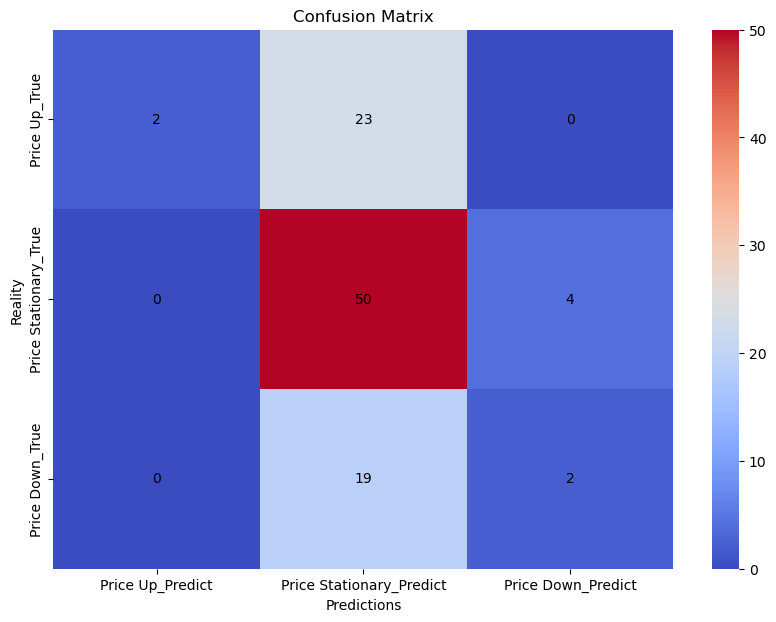

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predictions', ylabel='Reality'>

In [67]:
drawConfusion(KernelSVM["confusion"])

In [68]:
KernelSVMLasso = kernelSVM(X_lasso_train,y_train,X_lasso_test,y_test)
KernelSVMLasso

time: 3.235942840576172
SVC Model's Training set score: 0.628
SVC Model's Test set score: 0.510


{'accuracy': 0.51,
 'time': 3.235942840576172,
 'f1': 0.2503803131991051,
 'confusion': array([[ 0, 25,  0],
        [ 1, 50,  3],
        [ 0, 20,  1]], dtype=int64),
 'trainedModel': SVC(C=20, gamma=0.1),
 'y_pred': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.])}

The DataFrame of the Confusion Matrix generated is:
                       Price Up_Predict  Price Stationary_Predict  \
Price Up_True                         0                        25   
Price Stationary_True                 1                        50   
Price Down_True                       0                        20   

                       Price Down_Predict  
Price Up_True                           0  
Price Stationary_True                   3  
Price Down_True                         1  


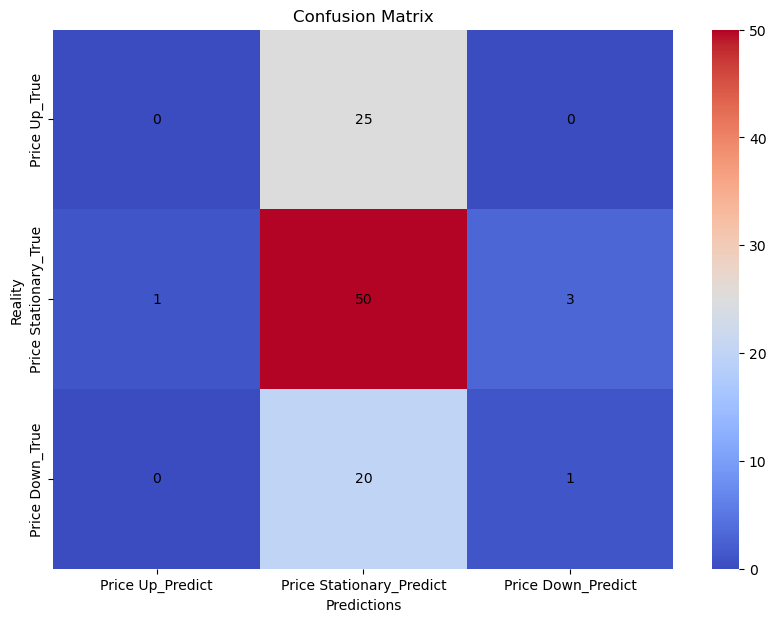

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predictions', ylabel='Reality'>

In [69]:
drawConfusion(KernelSVMLasso["confusion"])


## 7.6 Random Forest Classifier (Mohammed)

In [70]:
from sklearn.ensemble import RandomForestClassifier

def randomForest(X_train,y_train,X_test,y_test):
    
    rnd_clf = RandomForestClassifier(n_estimators=500, max_depth = 10,min_samples_split = 20, n_jobs=-1, random_state=42)
    # max_depth: The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
    # min_samples_split: The minimum number of samples required to split an internal node.
    # min_samples_leaf: The minimum number of samples required to be at a leaf node
    # max_leaf_nodes: The maximum number of leaf nodes

    result = getMultiLearningResult(rnd_clf,X_train,y_train,X_test,y_test)
    rnd_clf = result["trainedModel"]
        
    return result



RandomForest ={}
RandomForest = randomForest(X_train,y_train,X_test,y_test)
RandomForest

time: 4.17229700088501
RandomForestClassifier Model's Training set score: 0.744
RandomForestClassifier Model's Test set score: 0.520


{'accuracy': 0.52,
 'time': 4.17229700088501,
 'f1': 0.34019832189168575,
 'confusion': array([[ 7, 18,  0],
        [ 6, 45,  3],
        [ 0, 21,  0]], dtype=int64),
 'trainedModel': RandomForestClassifier(max_depth=10, min_samples_split=20, n_estimators=500,
                        n_jobs=-1, random_state=42),
 'y_pred': array([-1.,  0.,  0., -1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0., -1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,
         1.,  0., -1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,
         0., -1.,  0.,  0.,  0.,  1.,  0.,  0., -1.,  0.,  0., -1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,
        -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])}

The DataFrame of the Confusion Matrix generated is:
                       Price Up_Predict  Price Stationary_Predict  \
Price Up_True                         7                        18   
Price Stationary_True                 6                        45   
Price Down_True                       0                        21   

                       Price Down_Predict  
Price Up_True                           0  
Price Stationary_True                   3  
Price Down_True                         0  


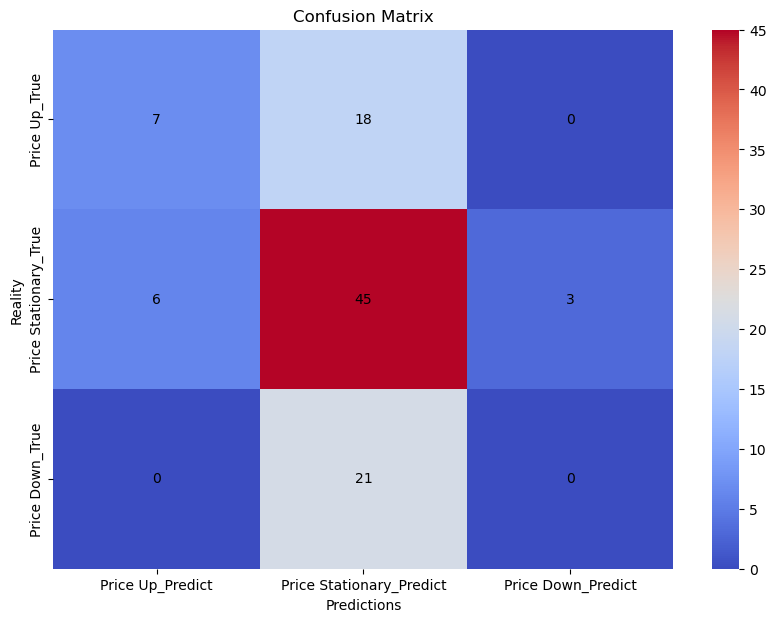

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predictions', ylabel='Reality'>

In [71]:
drawConfusion(RandomForest["confusion"])

In [72]:
RandomForestLasso = randomForest(X_lasso_train,y_train,X_lasso_test,y_test)
RandomForestLasso

time: 3.067883253097534
RandomForestClassifier Model's Training set score: 0.739
RandomForestClassifier Model's Test set score: 0.510


{'accuracy': 0.51,
 'time': 3.067883253097534,
 'f1': 0.32146234380276933,
 'confusion': array([[ 4, 21,  0],
        [ 6, 46,  2],
        [ 0, 20,  1]], dtype=int64),
 'trainedModel': RandomForestClassifier(max_depth=10, min_samples_split=20, n_estimators=500,
                        n_jobs=-1, random_state=42),
 'y_pred': array([-1.,  0.,  0., -1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,
         0.,  0., -1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0., -1.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0., -1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0., -1.])}

The DataFrame of the Confusion Matrix generated is:
                       Price Up_Predict  Price Stationary_Predict  \
Price Up_True                         4                        21   
Price Stationary_True                 6                        46   
Price Down_True                       0                        20   

                       Price Down_Predict  
Price Up_True                           0  
Price Stationary_True                   2  
Price Down_True                         1  


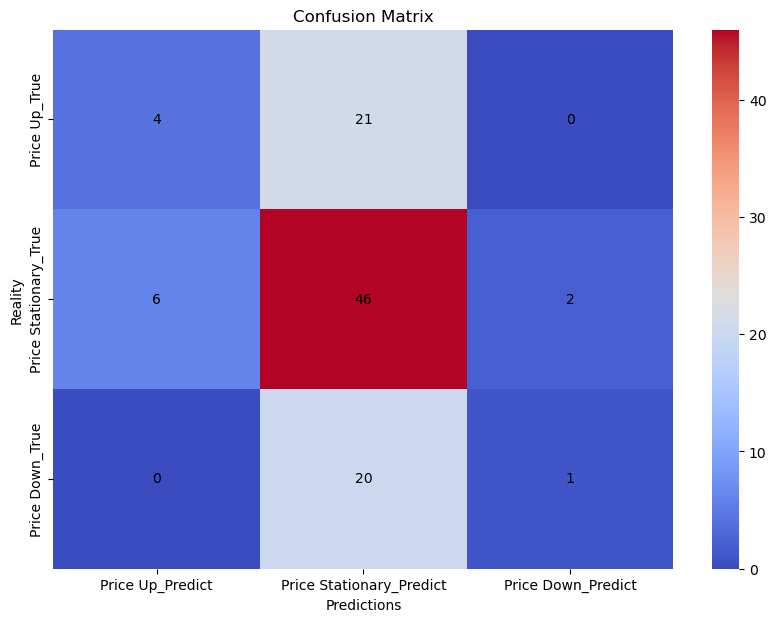

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predictions', ylabel='Reality'>

In [73]:
drawConfusion(RandomForestLasso["confusion"])


## 7.7 Ensemble Voting Classifier (Vivan Sun)

In [74]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

def voting(X_train,y_train,X_test,y_test):
    
    log_clf = LogisticRegression(solver="liblinear", random_state=42)
    rnd_clf = RandomForestClassifier(n_estimators=50, random_state=42)
    svm_clf = SVC(gamma="auto",  probability=True,random_state=42)
    
    voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],voting='hard')

    # If ‘hard’, uses predicted class labels for majority rule voting. 
    # Else if ‘soft’, predicts the class label based on the argmax of the sums of the predicted probabilities, which is recommended for an ensemble of well-calibrated classifiers.
    
    result = getMultiLearningResult(voting_clf,X_train,y_train,X_test,y_test)
    voting_clf = result["trainedModel"]
    
    for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print(clf.__class__.__name__, accuracy_score(y_test, y_pred))
        
    return result
    


Voting ={}
Voting = voting(X_train,y_train,X_test,y_test)
Voting


time: 64.7502076625824
VotingClassifier Model's Training set score: 0.652
VotingClassifier Model's Test set score: 0.530
LogisticRegression 0.52
RandomForestClassifier 0.52
SVC 0.54
VotingClassifier 0.53


{'accuracy': 0.53,
 'time': 64.7502076625824,
 'f1': 0.25427193197612624,
 'confusion': array([[ 1, 24,  0],
        [ 1, 52,  1],
        [ 0, 21,  0]], dtype=int64),
 'trainedModel': VotingClassifier(estimators=[('lr',
                               LogisticRegression(random_state=42,
                                                  solver='liblinear')),
                              ('rf',
                               RandomForestClassifier(n_estimators=50,
                                                      random_state=42)),
                              ('svc',
                               SVC(gamma='auto', probability=True,
                                   random_state=42))]),
 'y_pred': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  

The DataFrame of the Confusion Matrix generated is:
                       Price Up_Predict  Price Stationary_Predict  \
Price Up_True                         1                        24   
Price Stationary_True                 1                        52   
Price Down_True                       0                        21   

                       Price Down_Predict  
Price Up_True                           0  
Price Stationary_True                   1  
Price Down_True                         0  


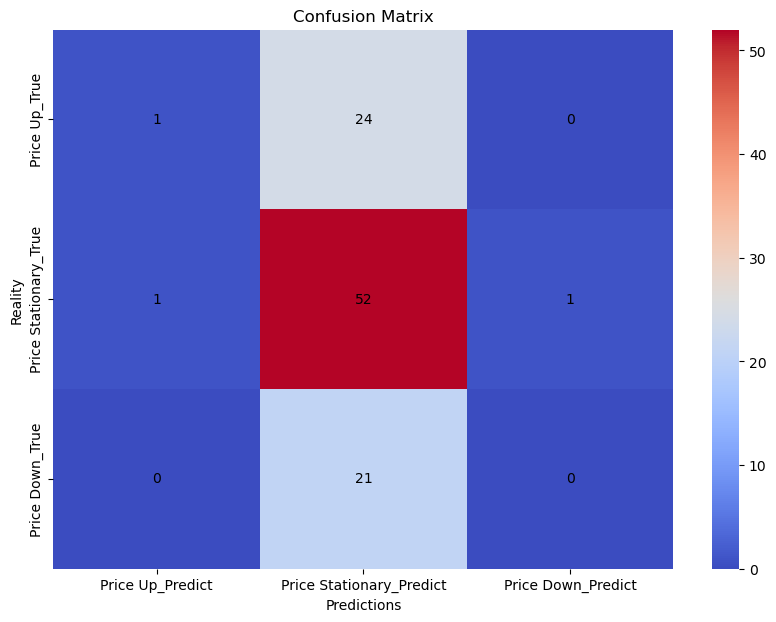

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predictions', ylabel='Reality'>

In [75]:
drawConfusion(Voting["confusion"])

In [76]:
VotingLasso = voting(X_lasso_train,y_train,X_lasso_test,y_test)
VotingLasso

time: 17.76103186607361
VotingClassifier Model's Training set score: 0.629
VotingClassifier Model's Test set score: 0.520
LogisticRegression 0.52
RandomForestClassifier 0.52
SVC 0.54
VotingClassifier 0.52


{'accuracy': 0.52,
 'time': 17.76103186607361,
 'f1': 0.2280701754385965,
 'confusion': array([[ 0, 25,  0],
        [ 1, 52,  1],
        [ 0, 21,  0]], dtype=int64),
 'trainedModel': VotingClassifier(estimators=[('lr',
                               LogisticRegression(random_state=42,
                                                  solver='liblinear')),
                              ('rf',
                               RandomForestClassifier(n_estimators=50,
                                                      random_state=42)),
                              ('svc',
                               SVC(gamma='auto', probability=True,
                                   random_state=42))]),
 'y_pred': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  

The DataFrame of the Confusion Matrix generated is:
                       Price Up_Predict  Price Stationary_Predict  \
Price Up_True                         0                        25   
Price Stationary_True                 1                        52   
Price Down_True                       0                        21   

                       Price Down_Predict  
Price Up_True                           0  
Price Stationary_True                   1  
Price Down_True                         0  


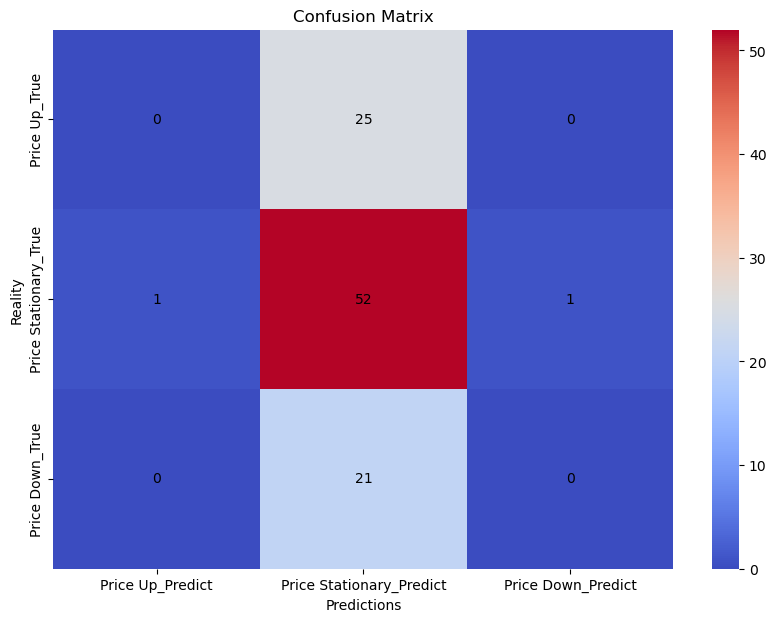

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predictions', ylabel='Reality'>

In [77]:
drawConfusion(VotingLasso["confusion"])

## 7.8 AdaBoost Classifier (albert)

In [78]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

def adaBoost(X_train,y_train,X_test,y_test):
    
    ada_clf = AdaBoostClassifier(
        LogisticRegression(class_weight={-1: 0.3,0: 0.2, 1: 0.4}), n_estimators=500,algorithm="SAMME.R", learning_rate=0.01, random_state=42)    
    result = getMultiLearningResult(ada_clf,X_train,y_train,X_test,y_test)
    ada_clf = result["trainedModel"]
        
    return result


AdaBoost = adaBoost(X_train,y_train,X_test,y_test)
AdaBoost

time: 51.972113847732544
AdaBoostClassifier Model's Training set score: 0.610
AdaBoostClassifier Model's Test set score: 0.530


{'accuracy': 0.53,
 'time': 51.972113847732544,
 'f1': 0.23093681917211328,
 'confusion': array([[ 0, 25,  0],
        [ 1, 53,  0],
        [ 0, 21,  0]], dtype=int64),
 'trainedModel': AdaBoostClassifier(estimator=LogisticRegression(class_weight={-1: 0.3, 0: 0.2,
                                                               1: 0.4}),
                    learning_rate=0.01, n_estimators=500, random_state=42),
 'y_pred': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.])}

The DataFrame of the Confusion Matrix generated is:
                       Price Up_Predict  Price Stationary_Predict  \
Price Up_True                         0                        25   
Price Stationary_True                 1                        53   
Price Down_True                       0                        21   

                       Price Down_Predict  
Price Up_True                           0  
Price Stationary_True                   0  
Price Down_True                         0  


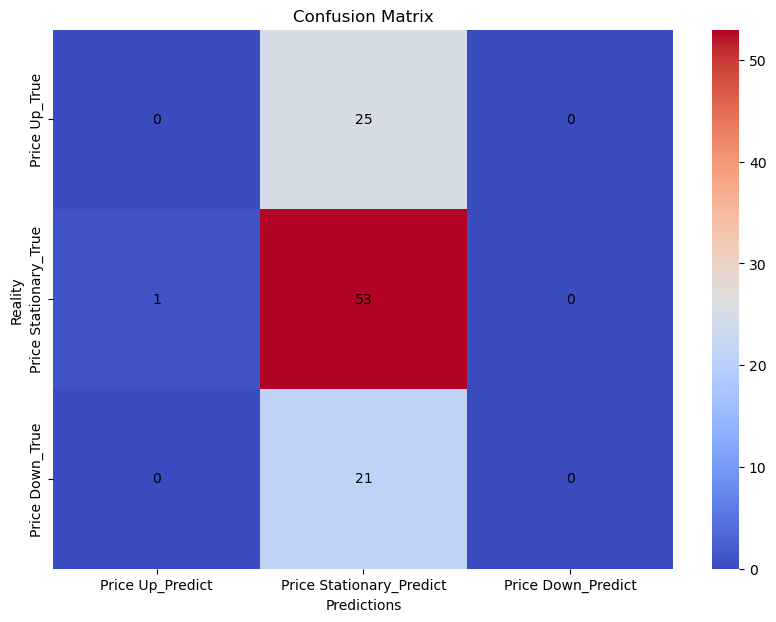

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predictions', ylabel='Reality'>

In [79]:
drawConfusion(AdaBoost["confusion"])

In [80]:
AdaBoostLasso = adaBoost(X_lasso_train,y_train,X_lasso_test,y_test)
AdaBoostLasso

time: 11.89647102355957
AdaBoostClassifier Model's Training set score: 0.610
AdaBoostClassifier Model's Test set score: 0.530


{'accuracy': 0.53,
 'time': 11.89647102355957,
 'f1': 0.23093681917211328,
 'confusion': array([[ 0, 25,  0],
        [ 1, 53,  0],
        [ 0, 21,  0]], dtype=int64),
 'trainedModel': AdaBoostClassifier(estimator=LogisticRegression(class_weight={-1: 0.3, 0: 0.2,
                                                               1: 0.4}),
                    learning_rate=0.01, n_estimators=500, random_state=42),
 'y_pred': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.])}

The DataFrame of the Confusion Matrix generated is:
                       Price Up_Predict  Price Stationary_Predict  \
Price Up_True                         0                        25   
Price Stationary_True                 1                        53   
Price Down_True                       0                        21   

                       Price Down_Predict  
Price Up_True                           0  
Price Stationary_True                   0  
Price Down_True                         0  


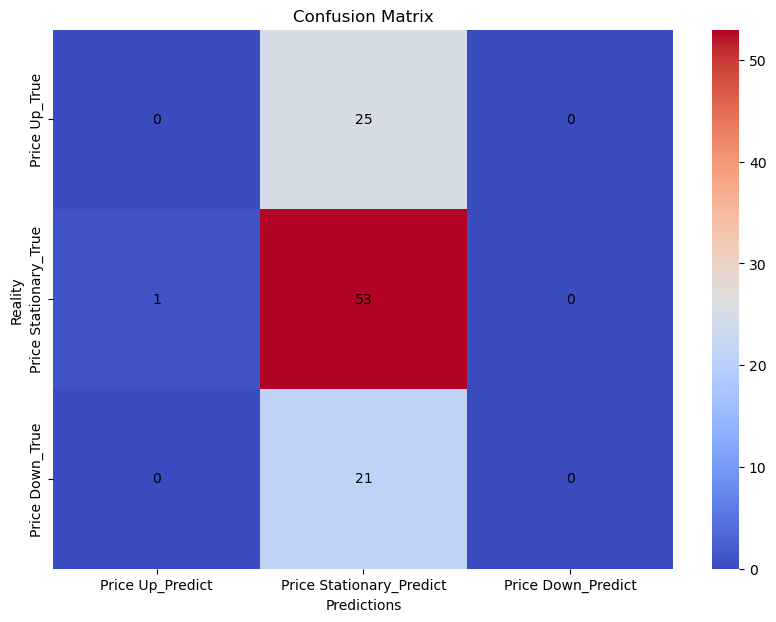

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predictions', ylabel='Reality'>

In [81]:
drawConfusion(AdaBoostLasso["confusion"])

# 8. Comparing ML algorithms : 

In [82]:
# Evaluation Metrics
time = pd.DataFrame({'Model': ['Logistic Regression', 'Logistic Regression (Lasso)', 'Decision Tree', 'Decision Tree (Lasso)', 'KNN', 'KNN (Lasso)', 'Naive Bayes', 'Naive Bayes (Lasso)', 'Linear SVM', 'Linear SVM (Lasso)', 'Kernel SVM', 'Kernel SVM (Lasso)', 'Random Forest', 'Random Forest (Lasso)', 'Voting', 'Voting (Lasso)', 'AdaBoost', 'AdaBoost (Lasso)'], 'Time': [LogReg['time'], LogRegLasso['time'], DecTree['time'], DecTreeLasso['time'], KNN['time'], KNNLasso['time'], NB['time'], NBLasso['time'], LinearSVM['time'], LinearSVMLasso['time'], KernelSVM['time'], KernelSVMLasso['time'], RandomForest['time'], RandomForestLasso['time'], Voting['time'], VotingLasso['time'], AdaBoost['time'], AdaBoostLasso['time']]})
time = time.sort_values(by='Time', ascending=False)

accuracy = pd.DataFrame({'Model': ['Logistic Regression', 'Logistic Regression (Lasso)', 'Decision Tree', 'Decision Tree (Lasso)', 'KNN', 'KNN (Lasso)', 'Naive Bayes', 'Naive Bayes (Lasso)', 'Linear SVM', 'Linear SVM (Lasso)', 'Kernel SVM', 'Kernel SVM (Lasso)', 'Random Forest', 'Random Forest (Lasso)', 'Voting', 'Voting (Lasso)', 'AdaBoost', 'AdaBoost (Lasso)'], 'Accuracy': [LogReg['accuracy'], LogRegLasso['accuracy'], DecTree['accuracy'], DecTreeLasso['accuracy'], KNN['accuracy'], KNNLasso['accuracy'], NB['accuracy'], NBLasso['accuracy'], LinearSVM['accuracy'], LinearSVMLasso['accuracy'], KernelSVM['accuracy'], KernelSVMLasso['accuracy'], RandomForest['accuracy'], RandomForestLasso['accuracy'], Voting['accuracy'], VotingLasso['accuracy'], AdaBoost['accuracy'], AdaBoostLasso['accuracy']]})
accuracy = accuracy.sort_values(by='Accuracy', ascending=False)

F1 = pd.DataFrame({'Model': ['Logistic Regression', 'Logistic Regression (Lasso)', 'Decision Tree', 'Decision Tree (Lasso)', 'KNN', 'KNN (Lasso)', 'Naive Bayes', 'Naive Bayes (Lasso)', 'Linear SVM', 'Linear SVM (Lasso)', 'Kernel SVM', 'Kernel SVM (Lasso)', 'Random Forest', 'Random Forest (Lasso)', 'Voting', 'Voting (Lasso)', 'AdaBoost', 'AdaBoost (Lasso)',], 'F1 Score': [LogReg['f1'], LogRegLasso['f1'], DecTree['f1'], DecTreeLasso['f1'], KNN['f1'], KNNLasso['f1'], NB['f1'], NBLasso['f1'], LinearSVM['f1'], LinearSVMLasso['f1'], KernelSVM['f1'], KernelSVMLasso['f1'], RandomForest['f1'], RandomForestLasso['f1'], Voting['f1'], VotingLasso['f1'], AdaBoost['f1'], AdaBoostLasso['f1']]})
F1 = F1.sort_values(by='F1 Score', ascending=False)

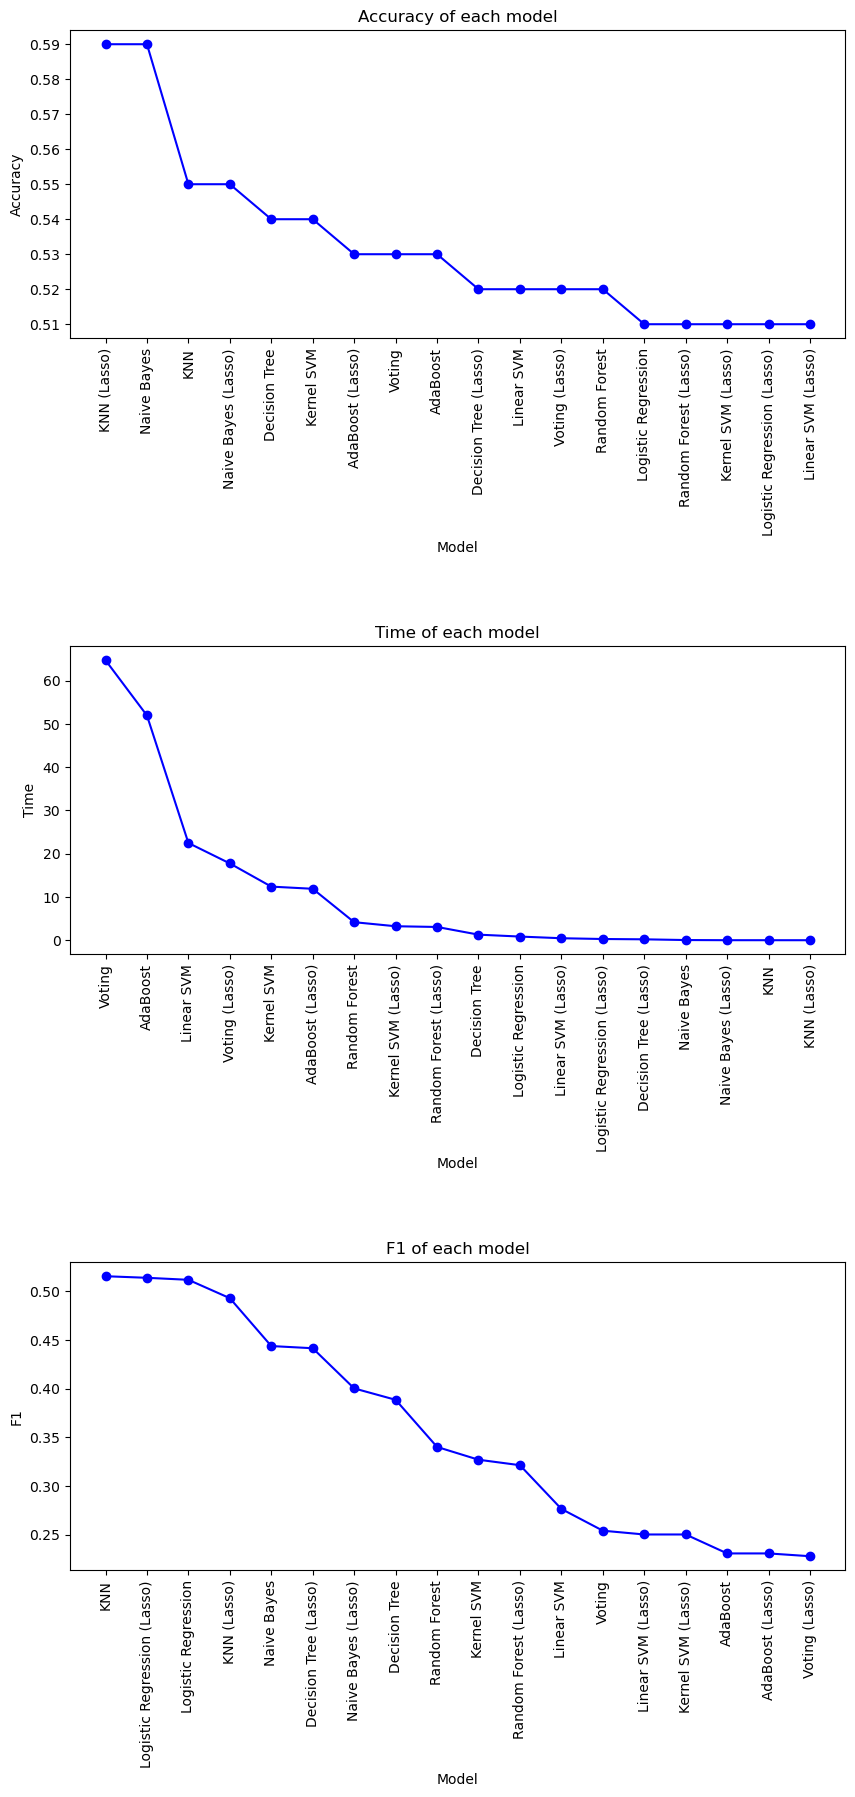

In [83]:
# cSpell:ignore figsize linestyle xlabel ylabel hspace
fig, axs = plt.subplots(3, 1, figsize=(10, 20))
axs[0].plot(accuracy['Model'], accuracy['Accuracy'], marker='o', linestyle='-', color='b')
axs[0].set_title('Accuracy of each model')
axs[0].set_xlabel('Model')
axs[0].set_ylabel('Accuracy')
axs[0].tick_params(axis='x', rotation=90)


axs[1].plot(time['Model'], time['Time'], marker='o', linestyle='-', color='b')
axs[1].set_title('Time of each model')
axs[1].set_xlabel('Model')
axs[1].set_ylabel('Time')
axs[1].tick_params(axis='x', rotation=90)

axs[2].plot(F1['Model'], F1['F1 Score'], marker='o', linestyle='-', color='b')
axs[2].set_title('F1 of each model')
axs[2].set_xlabel('Model')
axs[2].set_ylabel('F1')
axs[2].tick_params(axis='x', rotation=90)

plt.subplots_adjust(hspace=1)  # Adjust the spacing between subplots
plt.show()


In [84]:
# here we changed the heatmap function to create confusion matrix for all models.
import seaborn as sns
def drawConfusion(conf_array, ax, title):
    row_indices = ["Price Up_True", "Price Stationary_True", "Price Down_True"]
    column_names = ["Price Up_Predict", "Price Stationary_Predict", "Price Down_Predict"]
    
    conf_df = pd.DataFrame(conf_array, index=row_indices, columns=column_names)
    
    print(f"The DataFrame of the Confusion Matrix for {title} is:")
    print(conf_df)
    
    # Plot the confusion matrix using the provided ax
    heatmap = sns.heatmap(conf_df, cmap='coolwarm', cbar=True, ax=ax)
    ax.set_xlabel('Predictions')
    ax.set_ylabel('Reality')
    ax.set_title(title)

    # Annotate each cell with the respective numeric value
    for i in range(conf_df.shape[0]):
        for j in range(conf_df.shape[1]):
            ax.text(j + 0.5, i + 0.5, conf_df.iloc[i, j],
                    ha="center", va="center", color="black")
            
    return heatmap

The DataFrame of the Confusion Matrix for Logistic Regression is:
                       Price Up_Predict  Price Stationary_Predict  \
Price Up_True                        11                        14   
Price Stationary_True                12                        24   
Price Down_True                       0                         5   

                       Price Down_Predict  
Price Up_True                           0  
Price Stationary_True                  18  
Price Down_True                        16  
The DataFrame of the Confusion Matrix for Decision Tree is:
                       Price Up_Predict  Price Stationary_Predict  \
Price Up_True                        13                        12   
Price Stationary_True                11                        41   
Price Down_True                       1                        20   

                       Price Down_Predict  
Price Up_True                           0  
Price Stationary_True                   2  
Price Down_T

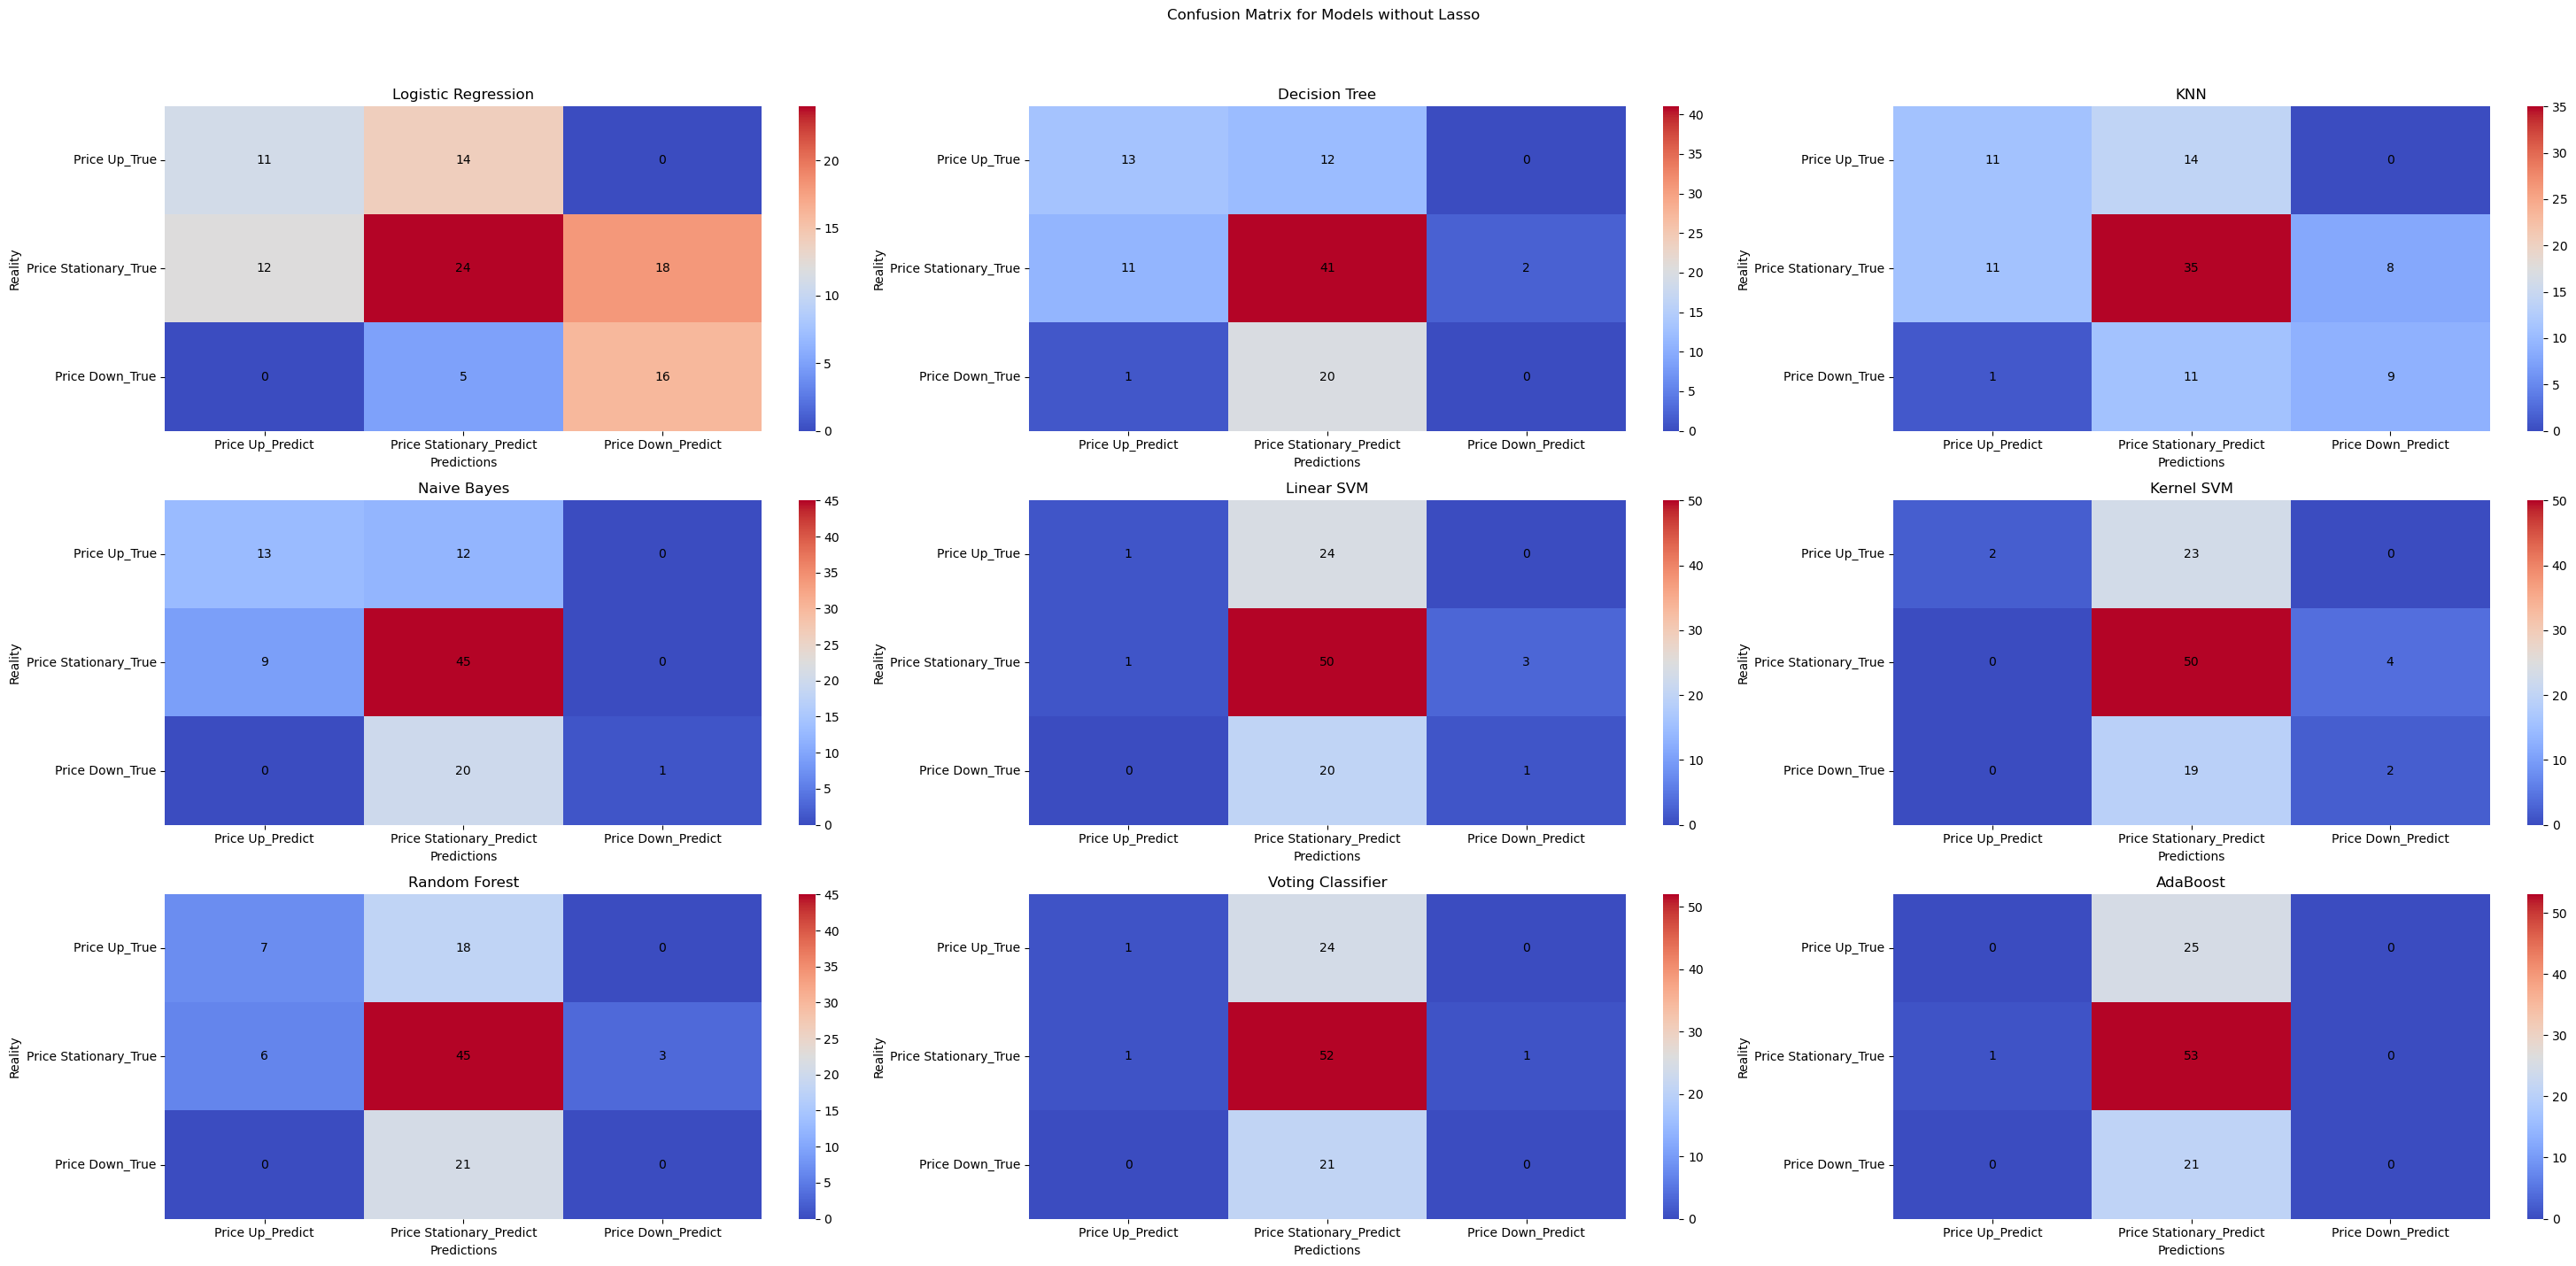

In [85]:
# This code is used to draw the confusion matrix for all models
model_titles = ["Logistic Regression", "Decision Tree", "KNN", 
                "Naive Bayes", "Linear SVM", "Kernel SVM", 
                "Random Forest", "Voting Classifier", "AdaBoost"]

fig, axs = plt.subplots(3, 3, figsize=(30, 15))
fig.suptitle('Confusion Matrix for Models without Lasso')

models = [LogReg, DecTree, KNN, NB, LinearSVM, KernelSVM, RandomForest, Voting, AdaBoost]

for i, model in enumerate(models):
    drawConfusion(model["confusion"], axs[i // 3, i % 3], model_titles[i])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

The DataFrame of the Confusion Matrix for Logistic Regression is:
                       Price Up_Predict  Price Stationary_Predict  \
Price Up_True                        11                        14   
Price Stationary_True                11                        22   
Price Down_True                       0                         3   

                       Price Down_Predict  
Price Up_True                           0  
Price Stationary_True                  21  
Price Down_True                        18  
The DataFrame of the Confusion Matrix for Decision Tree is:
                       Price Up_Predict  Price Stationary_Predict  \
Price Up_True                        10                        15   
Price Stationary_True                 7                        38   
Price Down_True                       0                        17   

                       Price Down_Predict  
Price Up_True                           0  
Price Stationary_True                   9  
Price Down_T

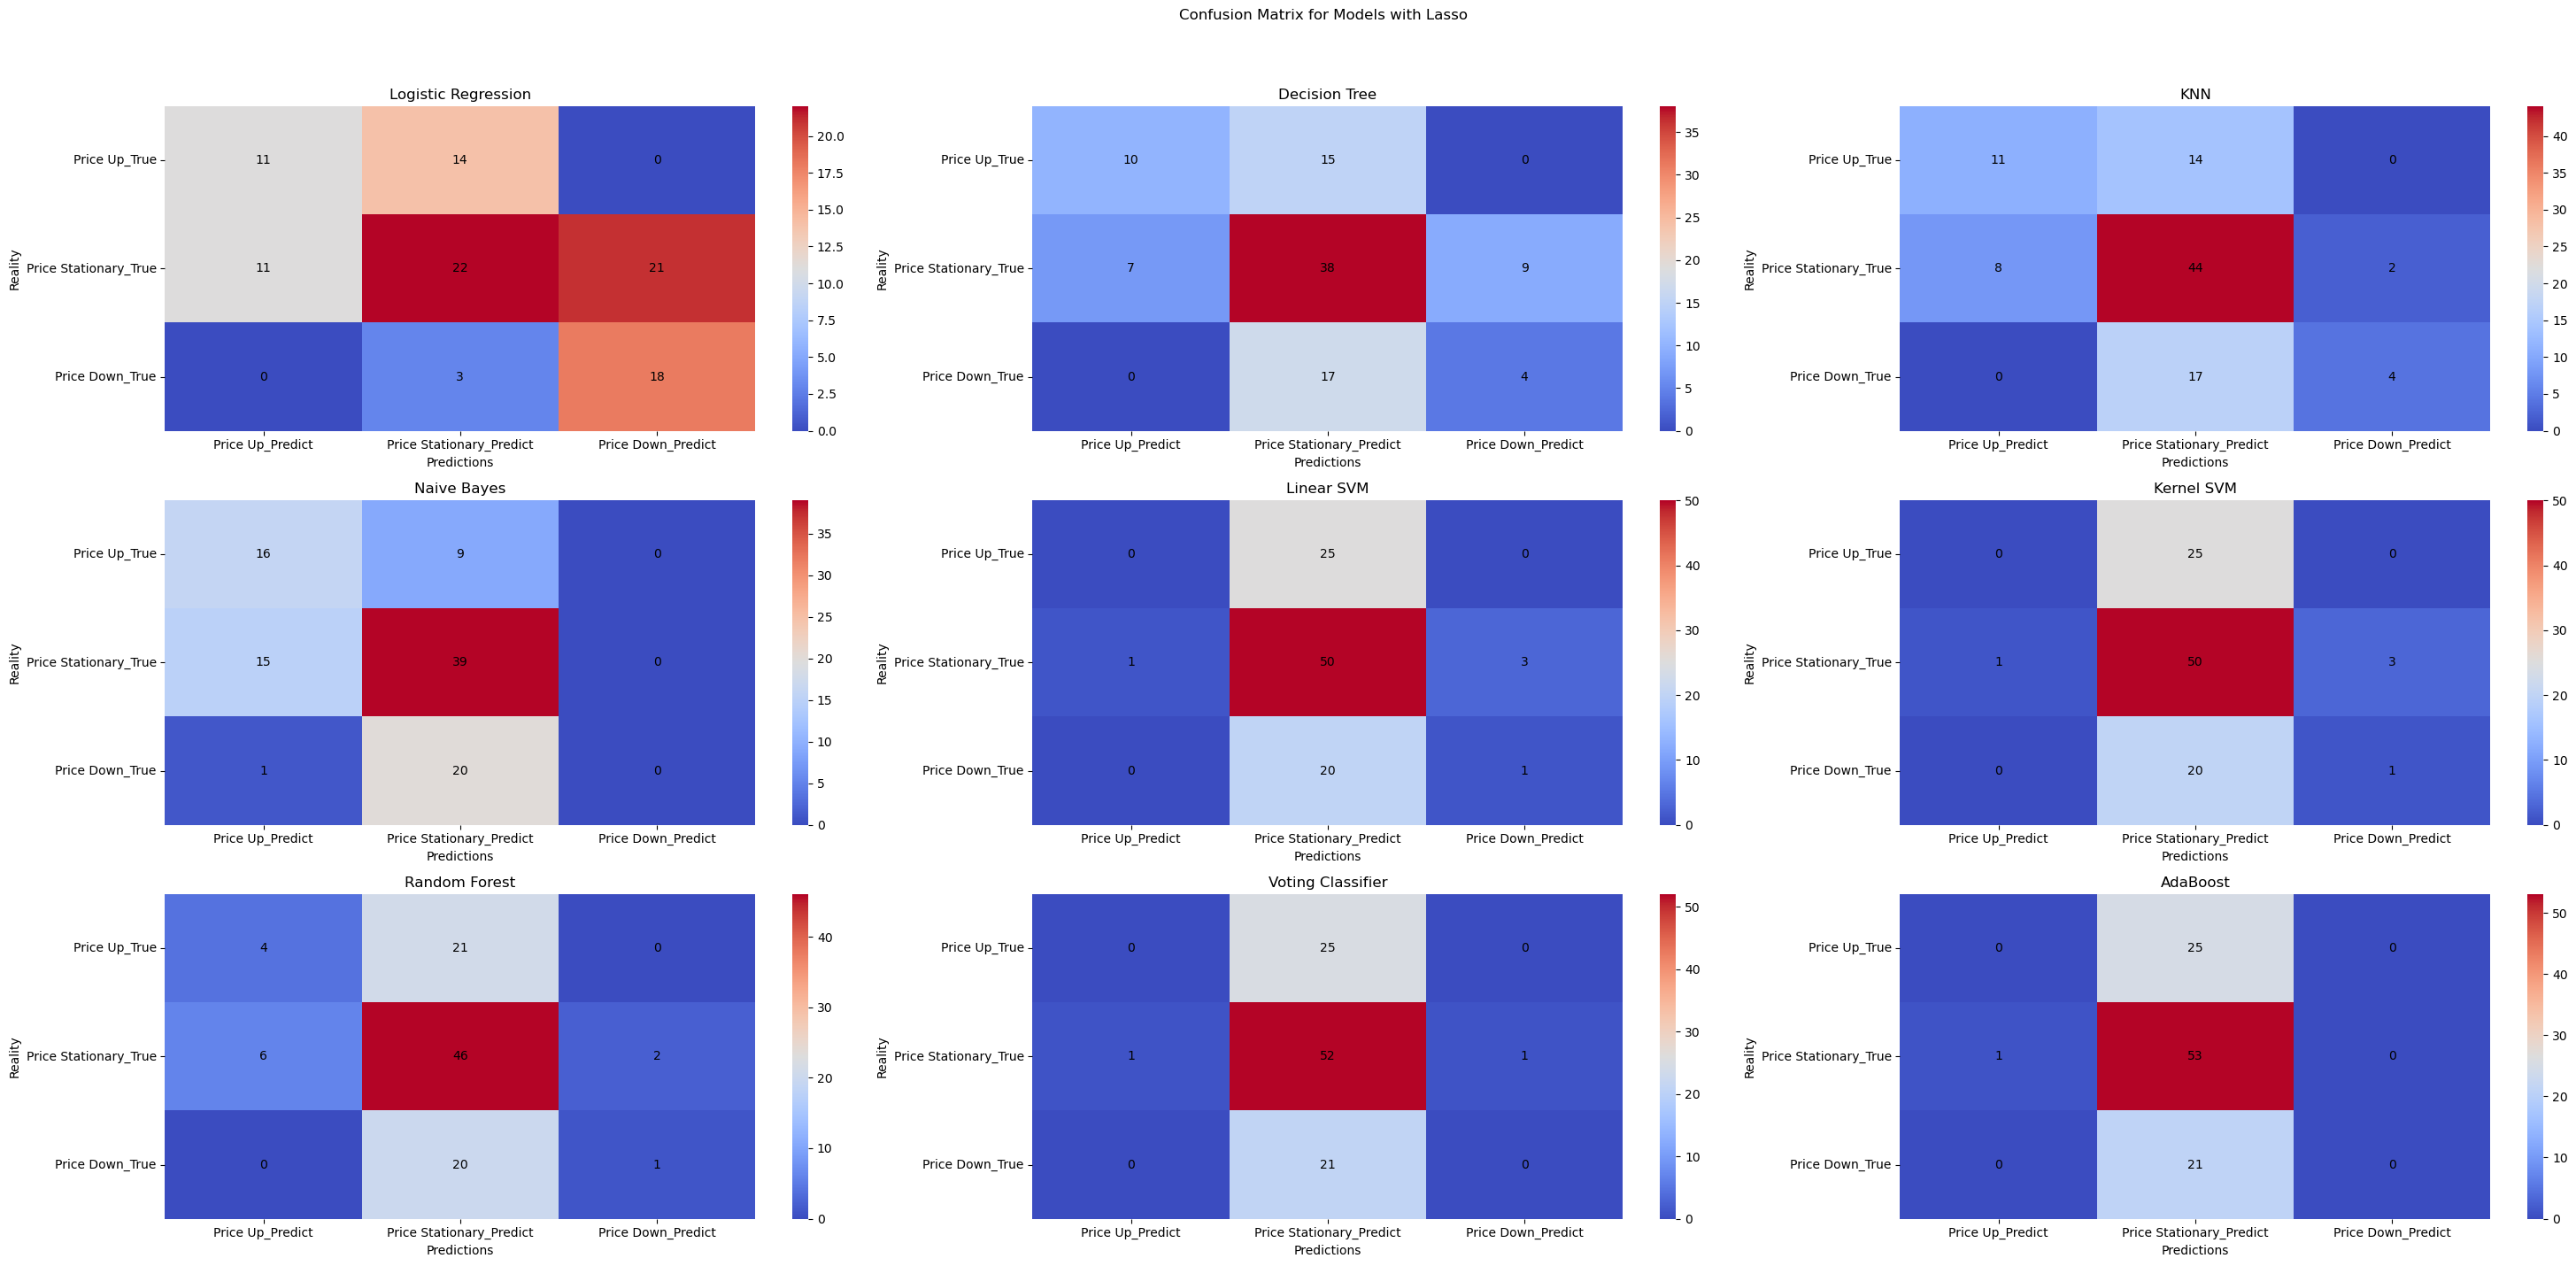

In [86]:
# This code is used to draw the confusion matrix for all lasso models
fig, axs = plt.subplots(3, 3, figsize=(30, 15))
fig.suptitle('Confusion Matrix for Models with Lasso')

lasso_models = [LogRegLasso, DecTreeLasso, KNNLasso, NBLasso, LinearSVMLasso, KernelSVMLasso, RandomForestLasso, VotingLasso, AdaBoostLasso]

for i, model in enumerate(lasso_models):
    drawConfusion(model["confusion"], axs[i // 3, i % 3], model_titles[i])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()


In [87]:
# how many times our prediction was correct. (albert) 


In [88]:
# For albert to enhance. (albert)